In [1]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from sem.generate_series import create_sde_process
from sem.sem.EM import NormalMixtureEM
from sem.sem.windows import Windows, calculate_acf


class EMForecaster(nn.Module):
    def __init__(self, 
                 window_size: int,
                 n_components: int = 3,
                 hidden_dim: int = 64,
                 n_em_iters: int = 5):
        super().__init__()
        
        self.dwindow_size = window_size - 1
        self.window_size = window_size
        self.n_components = n_components
        negative_slope = 0.01

        # self.dx_linear = nn.Linear(self.dwindow_size, self.dwindow_size, bias=False)

        self.em_layer = NormalMixtureEM(
            series_length=self.dwindow_size,
            n_components=n_components,
            n_sem_iters=n_em_iters
        )

        mlp_input_dim = self.dwindow_size * (n_components + 1)
        
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, hidden_dim, bias=False),
            nn.LeakyReLU(negative_slope),
            nn.Linear(hidden_dim, n_components, bias=False)
        )

        fusion_input_dim = n_components * 5
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, hidden_dim, bias=False),
            nn.LeakyReLU(negative_slope),
            nn.Linear(hidden_dim, 1, bias=False)
        )

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, negative_slope)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        

    def forward(self, X_window):
        batch_size = X_window.shape[0]

        dX1 = X_window[..., 1:] - X_window[..., :-1]
        g_ik, p_k, a_k, b_k = self.em_layer(dX1)

        dX_extended = torch.concat([dX1, (g_ik * dX1.unsqueeze(-1)).reshape((batch_size, -1))], dim=1)

        y_k = self.mlp(dX_extended)

        attention_logits = -b_k
        attention_weights = nn.functional.softmax(attention_logits, dim=1)

        fusion_input = torch.cat([
            y_k,
            attention_weights * y_k,
            a_k,
            attention_weights * a_k,
            p_k * a_k
        ], dim=1)
        forecast = X_window[..., -1] + self.fusion(fusion_input).squeeze(-1)

        self.last_em_outputs = {
            'g_ik': g_ik,
            'p_k': p_k,
            'a_k': a_k,
            'b_k': b_k,
            'y_k': y_k
        }
        
        return forecast

    def forward_multistep(self, windows, n_steps):
        forecasts = []
        for _ in range(n_steps):
            forecast = self.forward(windows)
            forecasts.append(forecast)

            windows = torch.cat([
                windows[:, 1:],
                forecast.unsqueeze(-1)
            ], dim=1)
        results = torch.stack(forecasts, dim=1)
        return results

    @torch.no_grad()
    def generate_forecast(self, idx, time_series, n_steps):
        if idx < 0:
            idx = time_series.shape[-1] + idx
        idx += 1  # to include current value in slice
        start_idx = idx - self.window_size
        ts = time_series[..., start_idx: idx]
        assert ts.shape[-1] == self.window_size, 'not enough data'

        if not isinstance(ts, torch.Tensor):
            ts = torch.tensor(ts, dtype=torch.float32)
        if ts.dim() == 1:
            ts = ts.unsqueeze(0)
        window = ts.to(self.parameters().__next__().device)

        preds = self.forward_multistep(window, n_steps)
        if ts.shape[0] == 1:
            preds = preds.squeeze(0)
        return preds
    
    def get_parameter_groups(self, em_lr: float, base_lr: float):
        em_params = []
        non_em_params = []
        
        for name, param in self.named_parameters():
            if 'em_layer' in name:
                em_params.append(param)
            else:
                non_em_params.append(param)
        
        return [
            {'params': non_em_params, 'lr': base_lr},
            {'params': em_params, 'lr': em_lr}
        ]



class TimeSeriesDataset(Dataset):
    def __init__(self, time_series: np.ndarray, N_init=5, N_add=5, alpha=0.6, n_train_steps=1):
        super().__init__()
        self.ts = time_series
        dts = time_series[1:] - time_series[:-1]
        *_, self.window_length = Windows()(dts, N_init=N_init, N_add=N_add, alpha=alpha)
        self.n_train_steps = n_train_steps
        self.window_length += 1

    def __len__(self):
        return len(self.ts) - self.window_length - self.n_train_steps

    def __getitem__(self, idx):
        idx_last = idx + self.window_length
        return self.ts[idx:idx_last], self.ts[idx_last: idx_last + self.n_train_steps]  # window, target
    

class MAPELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    
    def forward(self, predictions, targets):
        mape = torch.abs(predictions - targets) / (torch.abs(targets) + self.eps)
        return mape.mean()


class WeightedLoss(nn.Module):
    def __init__(self, mape=0.1, mse=1.0, eps=1e-8):
        super().__init__()
        self.mape = MAPELoss(eps)
        self.mse = nn.MSELoss()
        self.mape_weight = mape
        self.mse_weight = mse

    def forward(self, predictions, targets):
        return self.mape_weight * self.mape(predictions, targets) + self.mse_weight * self.mse(predictions, targets)

class Trainer:
    def __init__(self, time_series, len_train, n_train_steps, n_epochs=20, batch_size=64, n_components=3, alpha=0.7, lr=1e-4, sch_last_lr=1e-8, log_freq_batch=50, n_tests=100, n_test_steps=50, eps=1e-8, device='cuda'):
        self.train_series = time_series[:len_train]
        self.eval_series = time_series[len_train:]
        self.n_train_steps = n_train_steps
        dataset = TimeSeriesDataset(self.train_series, alpha=alpha, n_train_steps=n_train_steps)
        self.dataloader = DataLoader(dataset, batch_size, shuffle=True)

        self.window_size = dataset.window_length
        self.n_epochs = n_epochs
        self.n_tests = n_tests
        self.n_test_steps = n_test_steps

        self.model = EMForecaster(
            window_size=self.window_size,
            n_components=n_components,
            hidden_dim=64,
            n_em_iters=5
        ).to(device)

        self.optimizer = torch.optim.Adam(
            self.model.get_parameter_groups(lr * 0.1, lr)
        )

        self.scheduler = torch.optim.lr_scheduler.LinearLR(
            self.optimizer, 1.0, sch_last_lr, self.n_epochs
        )

        self.eps = eps
        self.criterion = WeightedLoss()

        self.device = device
        self.log_freq_batch = log_freq_batch
        

    @torch.no_grad()
    def validate(self):
        preds = self.model.generate_forecast(-1, self.train_series, self.n_test_steps).cpu()
        errors = np.array(preds) - self.eval_series[:self.n_test_steps]
        plt.plot(preds, label='Prediction')
        plt.plot(self.eval_series[:self.n_test_steps], label='Target')
        plt.legend()
        plt.title(f"Test MAE: {np.mean(np.abs(errors))}, Test bias: {np.mean(errors)}")
        plt.show()
    
    @torch.no_grad()
    def evaluate_multistep(self):
        step_errors = np.empty((self.n_tests, self.n_test_steps))
        for test in range(self.n_tests):
            idx = random.randint(self.window_size, len(self.train_series) - 1 - self.n_test_steps)
            target_idx = idx + 1
            preds = self.model.generate_forecast(idx, self.train_series, self.n_test_steps).cpu()
            step_errors[test, :] = np.array(preds) - self.train_series[target_idx:target_idx + self.n_test_steps]

        abs_errors = np.abs(step_errors)

        maes = np.mean(np.abs(step_errors), axis=0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

        ax1.hist(step_errors.flatten(), bins=50, alpha=0.7, edgecolor='black')
        ax1.axvline(x=0, color='r', linestyle='--')
        ax1.set_xlabel('Prediction Error')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Error Distribution')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(maes, 'o-')
        ax2.set_xlabel('Steps Ahead')
        ax2.set_ylabel('MAE')
        ax2.set_title('Error vs Prediction Horizon')
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.suptitle(f"Mean over steps over launches\nMAE:  {np.mean(abs_errors):.6f}, RMSE: {np.sqrt(np.mean(np.square(step_errors))):.6f}, Bias: {np.mean(step_errors):.6f}", y=1.1)
        plt.show()
        return step_errors

    def run(self):
        print(f"\nStarting training on {self.device}")
        print(f"Window size: {self.model.window_size}, Components: {self.model.n_components}")
        
        for epoch in range(1, self.n_epochs + 1):

            self.model.train()
            self.train_epoch(epoch)
            self.model.eval()

            self.validate()
            self.evaluate_multistep()
        print()
        print("Training completed!")
        return self.model
    
    def train_epoch(self, epoch_idx=0):
        print("Epoch:", epoch_idx)
        total_loss = 0.0

        for batch_idx, batch in enumerate(self.dataloader):
            windows, y = batch
            windows = windows.to(self.device).float()
            y = y.to(self.device).float()

            self.optimizer.zero_grad()

            results = self.model.forward_multistep(windows, self.n_train_steps)

            loss = self.criterion(results, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            self.optimizer.step()

            total_loss += loss.item()

            if batch_idx % self.log_freq_batch == 0:
                basic_metrics = self.compute_basic_metrics(results, y)
                em_metrics = self.get_em_metrics()
                grad_norm = self.compute_gradient_norm()
                print("Batch IDX:", batch_idx)
                print(basic_metrics)
                print(em_metrics)
                print("Grad_norm:", grad_norm)
                print()
            if torch.isnan(loss):
                print(f"WARNING: NaN loss at batch {batch_idx}")
                break
        self.scheduler.step()

        avg_loss = total_loss / len(self.dataloader)
        print(f"Epoch {epoch_idx} - Average Loss: {avg_loss:.6f}")

    @torch.no_grad()
    def get_em_metrics(self):
        """Minimal metrics"""
        if not hasattr(self.model, 'last_em_outputs'):
            return {}

        out = self.model.last_em_outputs
        g, a, b, y = out['g_ik'], out['a_k'], out['b_k'], out['y_k']
        k = g.shape[-1]
        em_params = {"EM weights": torch.exp(self.model.em_layer.weights.data),
                       "EM init_centers": self.model.em_layer.init_centers.data,
                       "EM init_scales": self.model.em_layer.init_scales.data,
                    }
        
        return {
            'entropy': -torch.sum(g * torch.log(g + self.eps), dim=-1).mean().item(),
            'active': (g.mean(dim=1) > (0.5 / k)).float().mean().item(),
            'means_std': a.std(dim=0).mean().item(),
            'stds_mean': b.mean().item(),
            'stds_std': b.std(dim=0).mean().item(),
            'corr': torch.corrcoef(torch.stack([y.flatten(), a.flatten()]))[0, 1].item(),
        } | em_params

    @torch.no_grad()
    def compute_basic_metrics(self, forecast, y_true):
        mae = torch.abs(forecast - y_true).mean().item()
        mse = torch.mean((forecast - y_true) ** 2).item()
        mape = torch.abs((forecast - y_true) / (y_true.abs() + self.eps)).mean().item() * 100
        return {'MAE': mae, 'MSE': mse, 'MAPE': mape}

    def compute_gradient_norm(self):
        """Compute total gradient norm for monitoring"""
        total_norm = 0.0
        for p in self.model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        return total_norm ** 0.5

-Поменять генерацию данных (разные p_k, a_k, b_k)

Создать несколько моделей от тех же входов (MLP, RNN,...)

Создать бенчмарк на генерируемых данных

Сравнить модели

In [2]:
from torchinfo import summary

test_window_size = 81
model = EMForecaster(test_window_size, 3)
print(model.parameters().__next__().device)

summary(model, input_data=[torch.ones((1, test_window_size), dtype=torch.float32)])

cpu


Layer (type:depth-idx)                   Output Shape              Param #
EMForecaster                             [1]                       --
├─NormalMixtureEM: 1-1                   [1, 80, 3]                91
├─Sequential: 1-2                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 64]                   20,480
│    └─LeakyReLU: 2-2                    [1, 64]                   --
│    └─Linear: 2-3                       [1, 3]                    192
├─Sequential: 1-3                        [1, 1]                    --
│    └─Linear: 2-4                       [1, 64]                   960
│    └─LeakyReLU: 2-5                    [1, 64]                   --
│    └─Linear: 2-6                       [1, 1]                    64
Total params: 21,787
Trainable params: 21,781
Non-trainable params: 6
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09

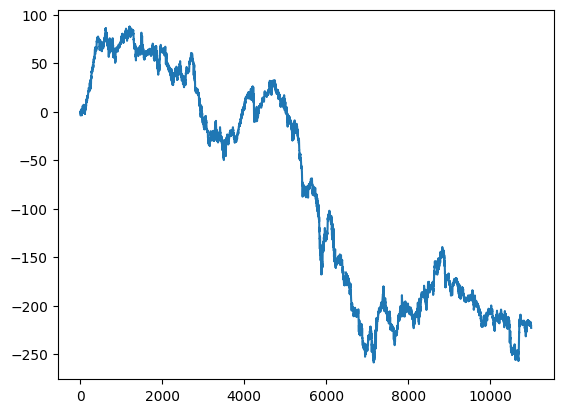

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)

num_components = 5
length = 11000

series = create_sde_process(length, n_components=num_components)['X']  # creates 1d time series of length=length
plt.plot(series)
plt.show()

N = 5; Max ACF(1): 1.0
N = 10; Max ACF(1): 0.9678092002868652
N = 15; Max ACF(1): 0.9429200291633606
N = 20; Max ACF(1): 0.9099183082580566


N = 25; Max ACF(1): 0.878044068813324
N = 30; Max ACF(1): 0.8670811057090759
N = 35; Max ACF(1): 0.8602907061576843
N = 40; Max ACF(1): 0.8534532785415649
N = 45; Max ACF(1): 0.8473802208900452
N = 50; Max ACF(1): 0.8388968706130981
N = 55; Max ACF(1): 0.8395543694496155
N = 60; Max ACF(1): 0.8200887441635132
N = 65; Max ACF(1): 0.8180908560752869
N = 70; Max ACF(1): 0.8095535635948181
N = 75; Max ACF(1): 0.8066509366035461
N = 80; Max ACF(1): 0.8094744682312012
N = 85; Max ACF(1): 0.8048690557479858
N = 90; Max ACF(1): 0.7990193963050842
N = 95; Max ACF(1): 0.789637565612793
N = 100; Max ACF(1): 0.7801791429519653
N = 105; Max ACF(1): 0.7711458206176758
N = 110; Max ACF(1): 0.7676361799240112
N = 115; Max ACF(1): 0.7479159235954285
Found window length: 115

Starting training on cuda
Window size: 116, Components: 5
Epoch: 1
Batch IDX: 0
{'MAE': 1.2648983001708984, 'MSE': 2.9966888427734375, 'MAPE': 3.171686828136444}
{'entropy': 1.6060179471969604, 'active': 1.0, 'means_std': 0.1488431

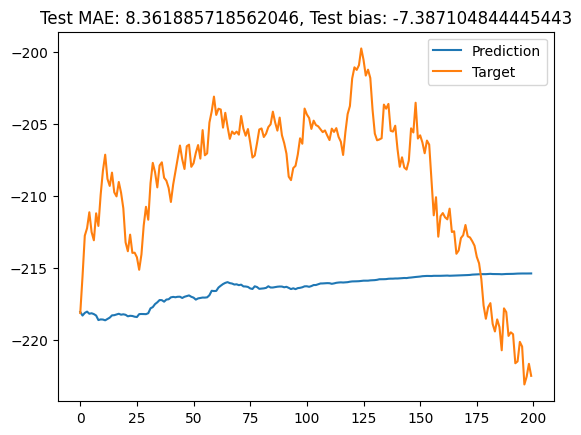

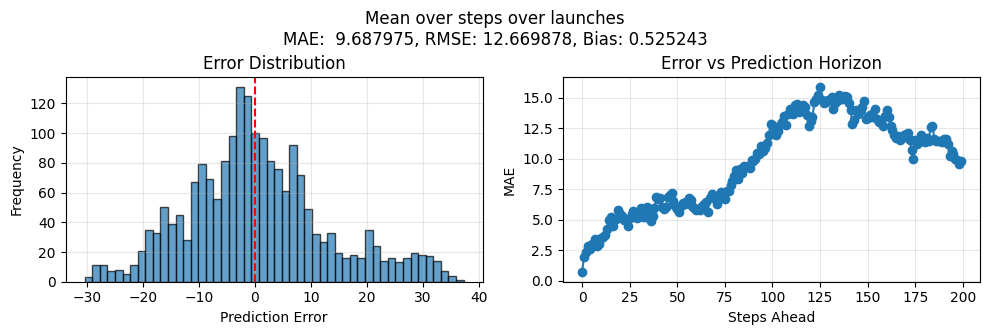

Epoch: 2
Batch IDX: 0
{'MAE': 1.0789203643798828, 'MSE': 2.1171398162841797, 'MAPE': 3.4560758620500565}
{'entropy': 1.6060726642608643, 'active': 1.0, 'means_std': 0.1445554941892624, 'stds_mean': 1.4367566108703613, 'stds_std': 0.45086660981178284, 'corr': -0.13651588559150696, 'EM weights': tensor([[0.9907, 0.9962, 1.0211, 0.9842, 1.0005, 1.0064, 1.0060, 0.9964, 1.0035,
         0.9956, 1.0126, 0.9981, 0.9892, 0.9979, 1.0174, 1.0017, 0.9955, 1.0101,
         0.9932, 1.0031, 1.0103, 0.9876, 0.9916, 0.9972, 0.9955, 0.9956, 0.9958,
         1.0100, 0.9920, 1.0107, 0.9941, 1.0038, 1.0110, 1.0016, 1.0112, 1.0016,
         1.0032, 0.9950, 1.0054, 1.0101, 0.9948, 0.9892, 0.9884, 1.0166, 0.9918,
         0.9955, 0.9916, 0.9970, 1.0028, 1.0050, 0.9947, 1.0010, 0.9966, 1.0060,
         0.9885, 1.0003, 0.9970, 0.9903, 0.9917, 1.0015, 1.0150, 1.0175, 1.0021,
         0.9812, 1.0029, 1.0044, 1.0021, 1.0022, 0.9961, 0.9902, 1.0068, 1.0027,
         0.9989, 0.9850, 0.9947, 0.9894, 0.9871, 1.0017, 

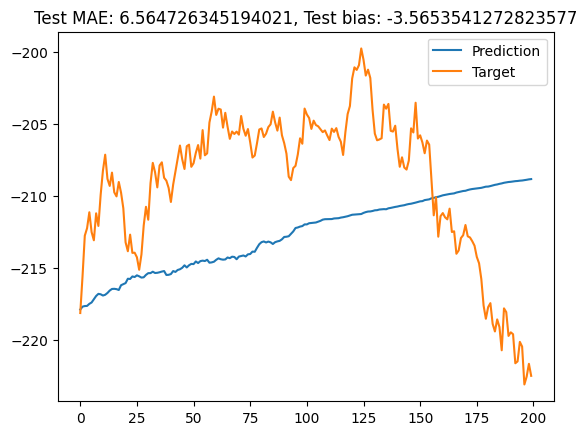

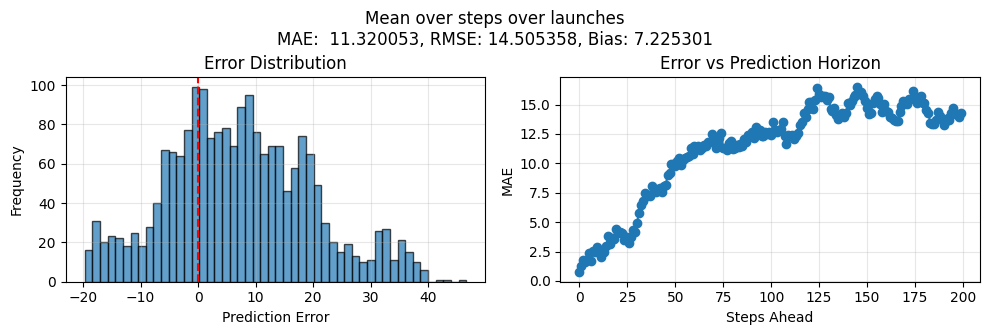

Epoch: 3
Batch IDX: 0
{'MAE': 1.1129465103149414, 'MSE': 2.0865280628204346, 'MAPE': 5.312001705169678}
{'entropy': 1.6064205169677734, 'active': 1.0, 'means_std': 0.1471436321735382, 'stds_mean': 1.4771074056625366, 'stds_std': 0.43164965510368347, 'corr': -0.11164647340774536, 'EM weights': tensor([[0.9869, 0.9927, 1.0275, 0.9836, 1.0083, 1.0104, 0.9959, 1.0132, 1.0112,
         0.9955, 1.0197, 1.0014, 0.9831, 0.9903, 1.0344, 1.0006, 0.9964, 1.0136,
         0.9959, 1.0042, 1.0153, 0.9790, 0.9953, 1.0053, 0.9915, 0.9962, 0.9966,
         1.0029, 0.9931, 1.0120, 0.9918, 1.0029, 1.0113, 0.9963, 1.0134, 1.0014,
         1.0045, 0.9901, 0.9995, 1.0065, 1.0005, 1.0052, 0.9775, 1.0191, 0.9872,
         1.0004, 0.9949, 1.0033, 1.0011, 1.0056, 0.9925, 0.9983, 0.9858, 1.0076,
         1.0028, 1.0003, 0.9889, 0.9905, 1.0016, 1.0102, 1.0205, 1.0158, 0.9928,
         0.9902, 1.0031, 1.0002, 1.0012, 0.9951, 0.9999, 0.9937, 0.9958, 1.0010,
         1.0118, 0.9867, 0.9814, 0.9922, 0.9830, 0.9944, 1

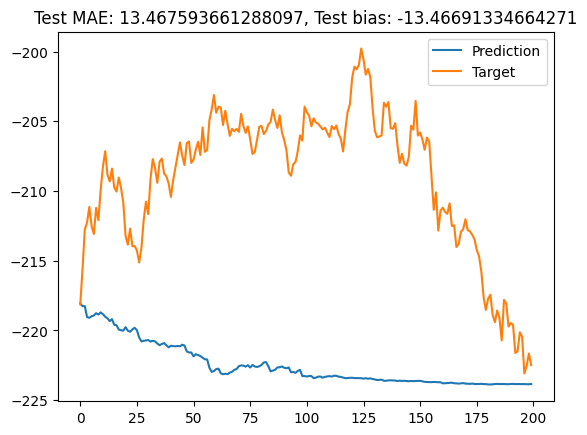

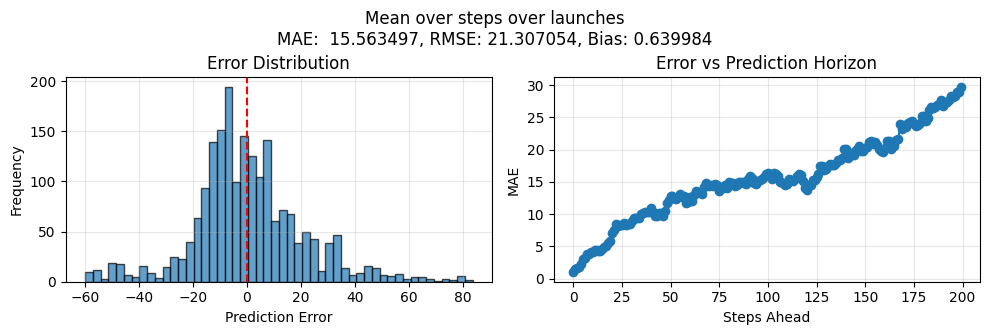

Epoch: 4
Batch IDX: 0
{'MAE': 1.125028371810913, 'MSE': 2.245361328125, 'MAPE': 3.244050219655037}
{'entropy': 1.6056851148605347, 'active': 1.0, 'means_std': 0.16005592048168182, 'stds_mean': 1.5460792779922485, 'stds_std': 0.5334131121635437, 'corr': -0.1199406087398529, 'EM weights': tensor([[0.9702, 0.9819, 1.0425, 0.9756, 1.0094, 0.9990, 0.9985, 1.0346, 0.9999,
         0.9906, 1.0190, 0.9978, 0.9894, 0.9841, 1.0394, 1.0014, 0.9881, 1.0192,
         0.9870, 1.0131, 1.0153, 0.9822, 1.0040, 1.0213, 1.0048, 0.9952, 1.0027,
         1.0056, 1.0059, 0.9983, 1.0169, 1.0127, 1.0210, 0.9842, 1.0165, 1.0137,
         0.9803, 0.9623, 1.0027, 0.9927, 1.0023, 0.9961, 0.9870, 1.0219, 0.9781,
         0.9956, 0.9975, 0.9939, 1.0163, 1.0131, 0.9794, 1.0127, 0.9859, 1.0017,
         1.0035, 0.9969, 0.9926, 0.9975, 0.9881, 1.0142, 1.0108, 1.0242, 0.9908,
         0.9956, 1.0147, 0.9975, 1.0029, 0.9954, 0.9934, 0.9919, 0.9979, 1.0255,
         1.0039, 0.9627, 0.9885, 1.0089, 0.9931, 0.9767, 1.0361,

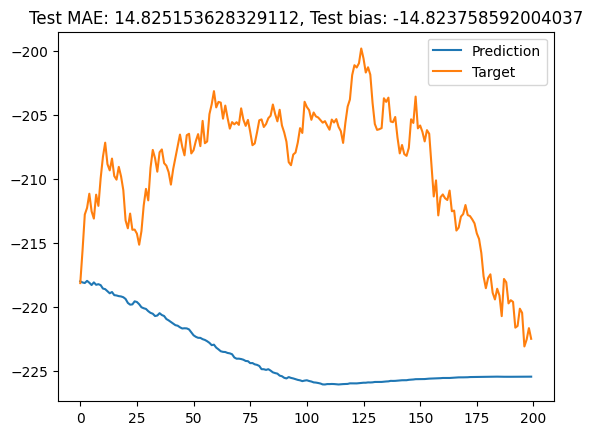

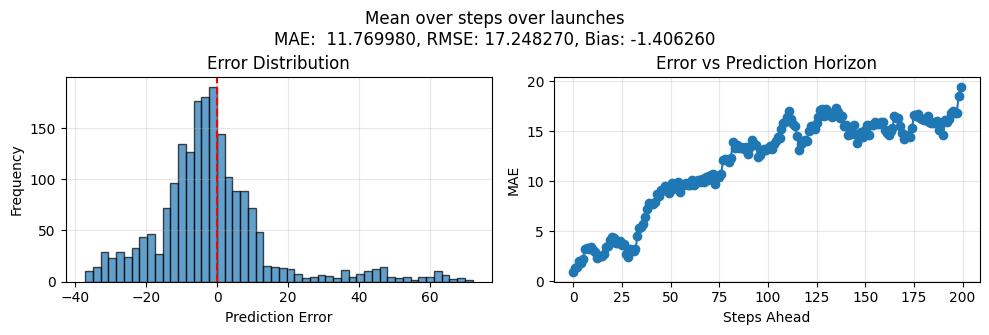

Epoch: 5
Batch IDX: 0
{'MAE': 1.0804874897003174, 'MSE': 2.0735325813293457, 'MAPE': 8.827168494462967}
{'entropy': 1.6055833101272583, 'active': 1.0, 'means_std': 0.17481669783592224, 'stds_mean': 1.4749349355697632, 'stds_std': 0.5276057124137878, 'corr': 0.059748489409685135, 'EM weights': tensor([[0.9674, 0.9674, 1.0325, 0.9869, 1.0210, 0.9993, 1.0005, 1.0172, 1.0037,
         0.9835, 1.0295, 1.0027, 0.9839, 0.9882, 1.0322, 1.0060, 0.9915, 1.0128,
         1.0010, 1.0054, 1.0245, 0.9782, 1.0170, 1.0237, 1.0084, 1.0022, 1.0023,
         1.0030, 0.9946, 0.9908, 1.0109, 1.0302, 1.0273, 0.9808, 1.0155, 1.0030,
         0.9739, 0.9502, 0.9974, 0.9890, 1.0143, 1.0015, 0.9875, 1.0273, 0.9627,
         1.0049, 0.9947, 1.0021, 1.0162, 1.0094, 0.9678, 1.0176, 0.9824, 0.9948,
         0.9938, 0.9965, 0.9793, 0.9991, 0.9891, 1.0194, 1.0000, 1.0092, 0.9737,
         1.0166, 1.0196, 1.0024, 1.0091, 0.9971, 0.9935, 0.9900, 1.0098, 1.0065,
         1.0122, 0.9603, 0.9747, 0.9954, 1.0026, 0.9664, 1

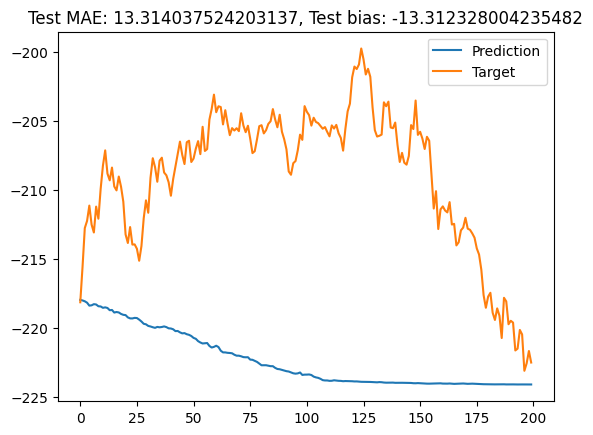

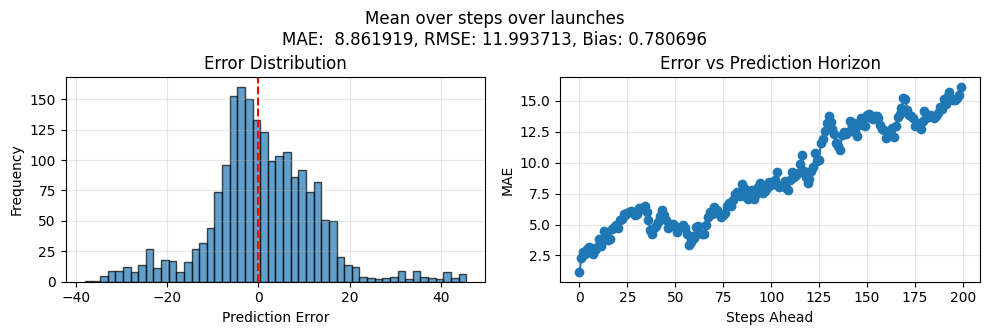

Epoch: 6
Batch IDX: 0
{'MAE': 1.051999807357788, 'MSE': 2.029104471206665, 'MAPE': 4.9143824726343155}
{'entropy': 1.6042506694793701, 'active': 1.0, 'means_std': 0.15652605891227722, 'stds_mean': 1.4893646240234375, 'stds_std': 0.5347779393196106, 'corr': -0.12026988714933395, 'EM weights': tensor([[0.9692, 0.9638, 1.0415, 0.9909, 1.0249, 0.9977, 0.9983, 1.0110, 1.0013,
         0.9770, 1.0388, 1.0012, 0.9776, 0.9910, 1.0319, 0.9865, 1.0003, 1.0132,
         0.9995, 1.0084, 1.0128, 0.9717, 1.0189, 1.0323, 1.0127, 1.0007, 1.0043,
         1.0084, 0.9991, 1.0065, 1.0143, 1.0386, 1.0255, 0.9804, 1.0252, 1.0033,
         0.9703, 0.9582, 0.9908, 0.9854, 1.0421, 1.0019, 0.9815, 1.0232, 0.9657,
         1.0024, 1.0008, 1.0015, 1.0169, 1.0040, 0.9666, 1.0251, 0.9804, 0.9957,
         0.9898, 0.9965, 0.9707, 0.9821, 0.9933, 1.0293, 1.0026, 0.9988, 0.9676,
         1.0343, 1.0138, 1.0006, 1.0078, 0.9944, 0.9912, 0.9816, 1.0104, 0.9999,
         1.0126, 0.9663, 0.9805, 0.9875, 1.0091, 0.9562, 1.

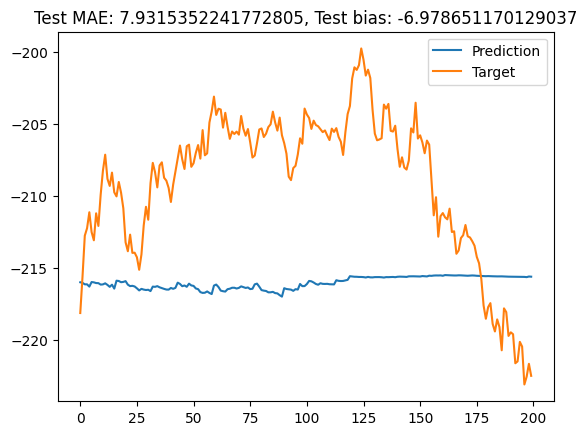

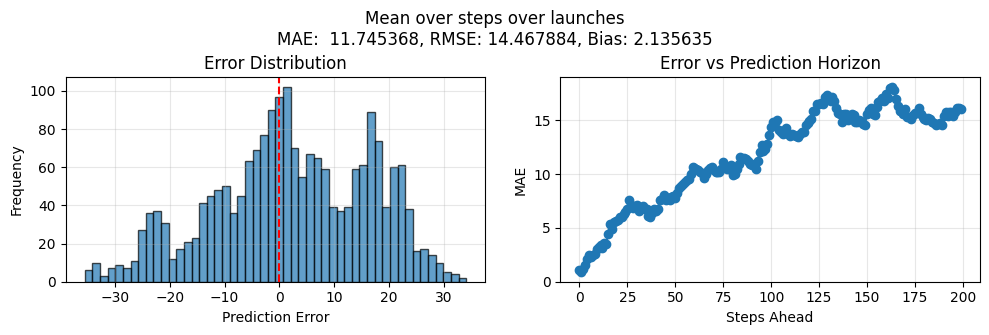

Epoch: 7
Batch IDX: 0
{'MAE': 1.013298511505127, 'MSE': 1.6146271228790283, 'MAPE': 1.9056543707847595}
{'entropy': 1.6042616367340088, 'active': 1.0, 'means_std': 0.16750173270702362, 'stds_mean': 1.479702115058899, 'stds_std': 0.5593311190605164, 'corr': -0.025326425209641457, 'EM weights': tensor([[0.9729, 0.9671, 1.0526, 0.9763, 1.0357, 0.9947, 1.0043, 1.0084, 0.9965,
         0.9706, 1.0404, 1.0052, 0.9722, 0.9930, 1.0305, 0.9850, 1.0020, 0.9965,
         1.0028, 1.0015, 1.0079, 0.9895, 1.0238, 1.0349, 1.0122, 1.0001, 1.0133,
         1.0117, 1.0065, 0.9983, 1.0169, 1.0406, 1.0265, 0.9806, 1.0247, 0.9966,
         0.9721, 0.9642, 0.9783, 0.9845, 1.0458, 1.0045, 0.9781, 1.0347, 0.9696,
         0.9939, 1.0024, 1.0068, 1.0051, 1.0040, 0.9610, 1.0201, 0.9771, 0.9991,
         1.0039, 0.9981, 0.9592, 0.9752, 0.9973, 1.0274, 0.9988, 0.9874, 0.9706,
         1.0413, 1.0133, 0.9951, 1.0075, 0.9970, 0.9888, 0.9771, 1.0074, 0.9974,
         1.0090, 0.9740, 0.9818, 0.9801, 1.0080, 0.9457, 1

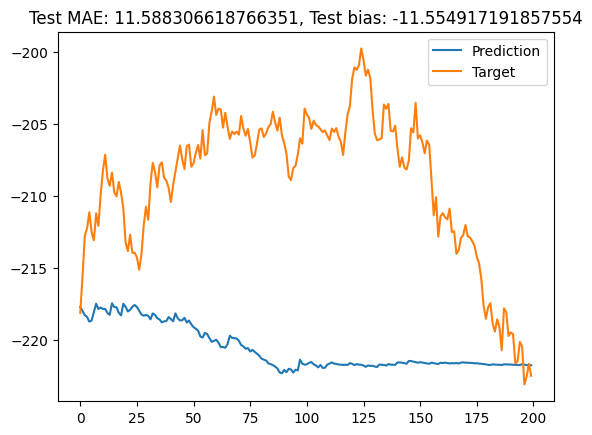

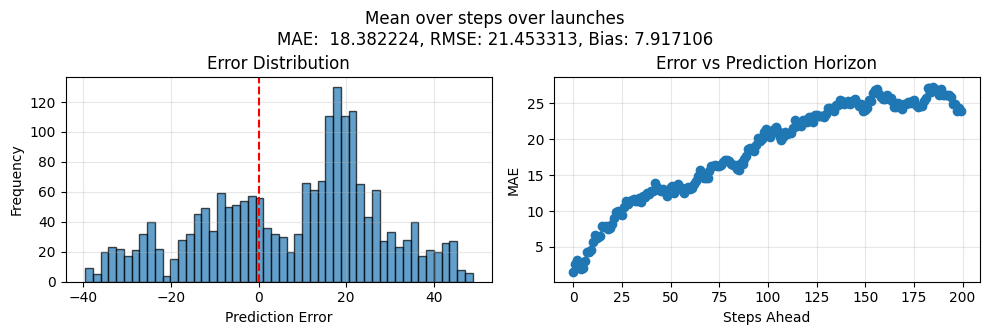

Epoch: 8
Batch IDX: 0
{'MAE': 1.068216323852539, 'MSE': 2.2825875282287598, 'MAPE': 5.905454978346825}
{'entropy': 1.602235198020935, 'active': 1.0, 'means_std': 0.14373748004436493, 'stds_mean': 1.4844963550567627, 'stds_std': 0.41152915358543396, 'corr': -0.00916098989546299, 'EM weights': tensor([[0.9679, 0.9503, 1.0685, 0.9701, 1.0280, 0.9944, 1.0114, 1.0065, 0.9949,
         0.9736, 1.0516, 0.9927, 0.9739, 0.9920, 1.0279, 0.9846, 0.9951, 0.9817,
         0.9973, 1.0083, 1.0096, 0.9805, 1.0339, 1.0323, 1.0079, 1.0151, 1.0318,
         1.0095, 1.0125, 1.0016, 1.0233, 1.0370, 1.0279, 0.9833, 1.0175, 0.9931,
         0.9637, 0.9567, 0.9690, 0.9730, 1.0569, 1.0218, 0.9834, 1.0382, 0.9682,
         0.9876, 1.0037, 1.0113, 0.9912, 1.0030, 0.9551, 1.0158, 0.9716, 0.9973,
         1.0034, 1.0016, 0.9715, 0.9738, 1.0003, 1.0454, 0.9809, 0.9696, 0.9786,
         1.0650, 1.0019, 0.9808, 1.0101, 0.9835, 0.9729, 0.9664, 1.0098, 1.0019,
         1.0020, 0.9932, 1.0034, 0.9763, 1.0005, 0.9182, 1.

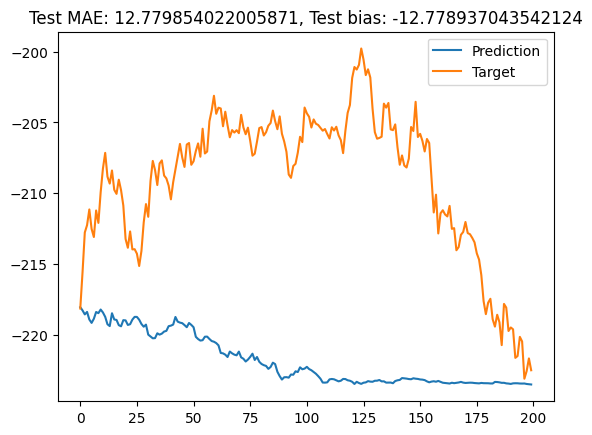

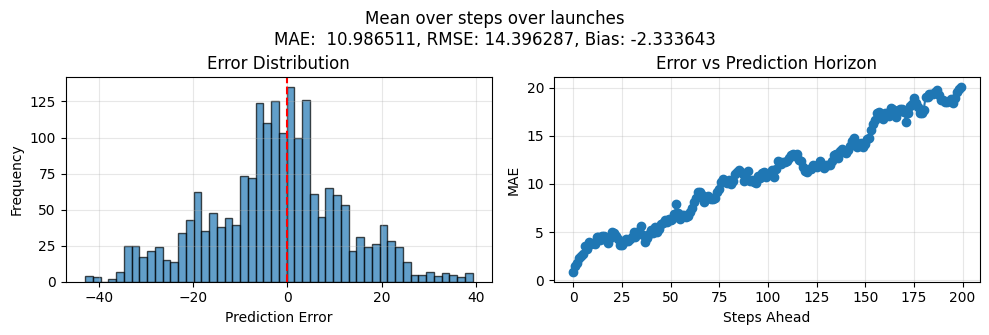

Epoch: 9
Batch IDX: 0
{'MAE': 1.0294346809387207, 'MSE': 1.7788617610931396, 'MAPE': 3.4917615354061127}
{'entropy': 1.6012582778930664, 'active': 1.0, 'means_std': 0.15338954329490662, 'stds_mean': 1.4311739206314087, 'stds_std': 0.45954838395118713, 'corr': -0.07547008991241455, 'EM weights': tensor([[0.9673, 0.9389, 1.0829, 0.9657, 1.0256, 0.9827, 0.9954, 1.0004, 1.0041,
         0.9650, 1.0537, 0.9837, 0.9824, 1.0067, 1.0344, 0.9792, 1.0038, 0.9567,
         0.9839, 1.0191, 1.0130, 0.9826, 1.0406, 1.0500, 1.0049, 1.0135, 1.0398,
         1.0150, 1.0106, 0.9942, 1.0305, 1.0293, 1.0217, 0.9789, 1.0097, 0.9913,
         0.9741, 0.9460, 0.9641, 0.9606, 1.0701, 1.0252, 0.9768, 1.0506, 0.9703,
         0.9878, 1.0074, 1.0128, 0.9864, 1.0145, 0.9532, 1.0069, 0.9636, 1.0100,
         0.9861, 0.9986, 0.9693, 0.9865, 0.9995, 1.0487, 0.9716, 0.9602, 0.9907,
         1.0867, 0.9939, 0.9668, 0.9985, 0.9865, 0.9787, 0.9493, 1.0148, 1.0059,
         0.9899, 0.9926, 1.0104, 0.9568, 0.9873, 0.9004,

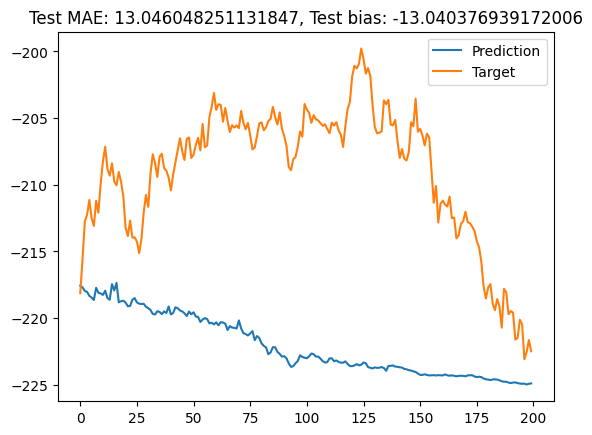

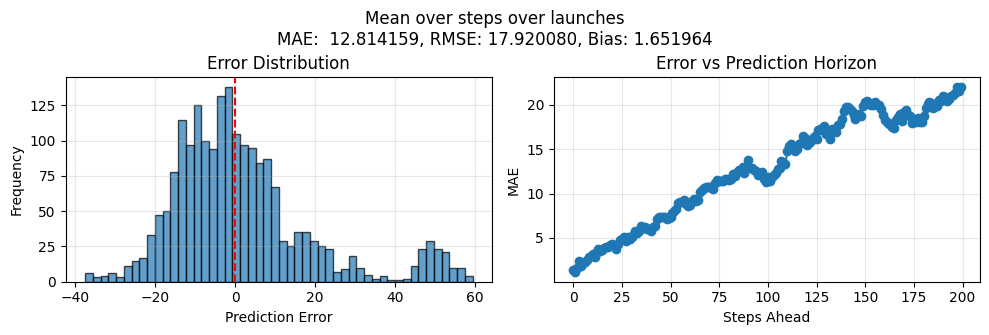

Epoch: 10
Batch IDX: 0
{'MAE': 1.0594549179077148, 'MSE': 1.7830018997192383, 'MAPE': 3.426002711057663}
{'entropy': 1.5990381240844727, 'active': 1.0, 'means_std': 0.1664450317621231, 'stds_mean': 1.5047897100448608, 'stds_std': 0.5428022146224976, 'corr': -0.06322360038757324, 'EM weights': tensor([[0.9728, 0.9287, 1.0783, 0.9604, 1.0090, 0.9787, 0.9868, 0.9959, 1.0084,
         0.9477, 1.0517, 0.9719, 0.9779, 1.0080, 1.0323, 0.9713, 1.0034, 0.9401,
         0.9735, 1.0284, 1.0202, 0.9864, 1.0378, 1.0539, 0.9972, 1.0139, 1.0486,
         1.0137, 1.0055, 0.9881, 1.0426, 1.0234, 1.0165, 0.9806, 1.0035, 0.9960,
         0.9733, 0.9470, 0.9518, 0.9564, 1.0809, 1.0246, 0.9644, 1.0689, 0.9785,
         0.9861, 1.0227, 1.0193, 0.9909, 1.0146, 0.9546, 1.0024, 0.9564, 1.0120,
         0.9750, 1.0021, 0.9739, 0.9825, 0.9954, 1.0423, 0.9737, 0.9502, 0.9819,
         1.1074, 0.9843, 0.9729, 0.9820, 0.9851, 0.9593, 0.9441, 1.0264, 1.0032,
         0.9720, 0.9916, 1.0056, 0.9518, 0.9723, 0.8987, 1

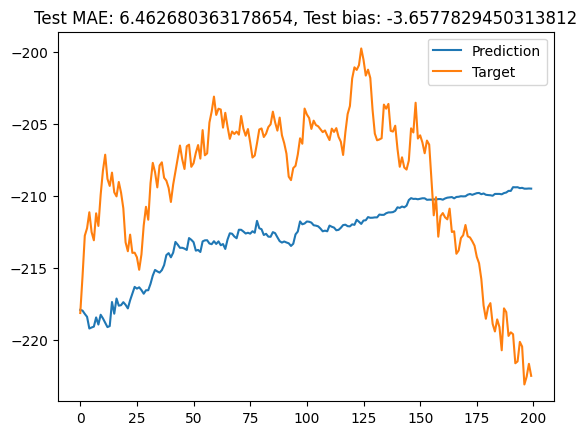

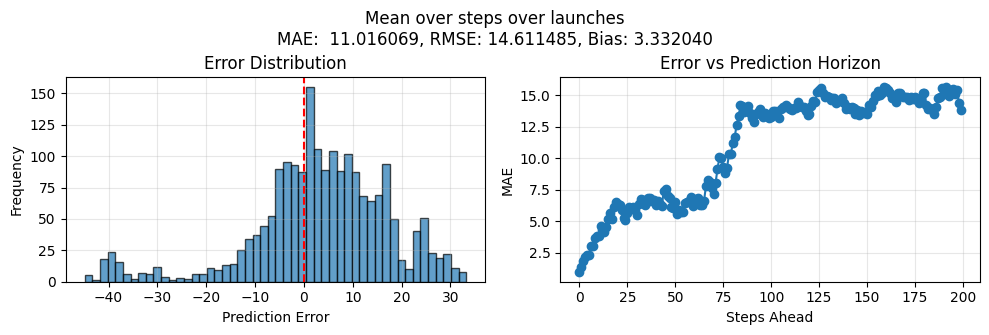

Epoch: 11
Batch IDX: 0
{'MAE': 0.8698124885559082, 'MSE': 1.3367793560028076, 'MAPE': 3.999420255422592}
{'entropy': 1.5933445692062378, 'active': 1.0, 'means_std': 0.15995018184185028, 'stds_mean': 1.4563874006271362, 'stds_std': 0.4917464256286621, 'corr': 0.04926262050867081, 'EM weights': tensor([[0.9733, 0.9336, 1.0729, 0.9569, 0.9991, 0.9792, 0.9872, 0.9857, 1.0008,
         0.9382, 1.0619, 0.9482, 0.9721, 1.0069, 1.0346, 0.9721, 0.9959, 0.9219,
         0.9762, 1.0285, 1.0251, 0.9763, 1.0199, 1.0599, 1.0012, 1.0158, 1.0651,
         1.0123, 1.0106, 0.9723, 1.0556, 1.0307, 1.0023, 0.9729, 0.9943, 0.9967,
         0.9807, 0.9196, 0.9360, 0.9567, 1.0843, 1.0298, 0.9682, 1.0721, 0.9779,
         0.9823, 1.0391, 1.0413, 0.9849, 1.0186, 0.9527, 1.0045, 0.9433, 1.0264,
         0.9521, 0.9918, 0.9606, 0.9877, 0.9947, 1.0370, 0.9723, 0.9455, 0.9685,
         1.1341, 0.9785, 0.9749, 0.9646, 0.9922, 0.9414, 0.9210, 1.0335, 0.9945,
         0.9569, 1.0080, 1.0162, 0.9610, 0.9629, 0.8955, 1

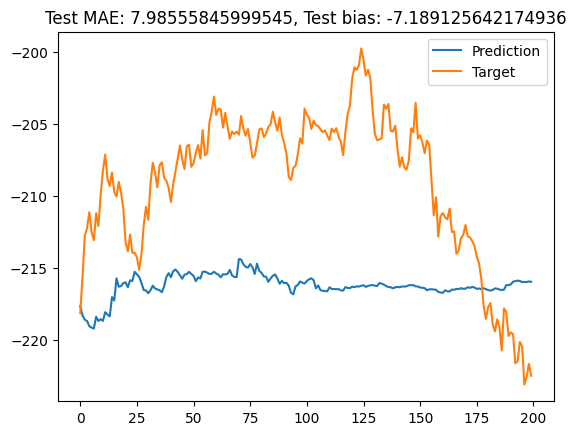

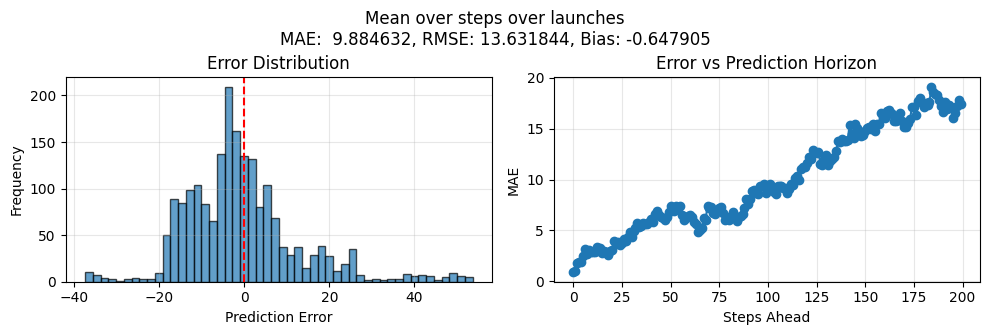

Epoch: 12
Batch IDX: 0
{'MAE': 0.9161461591720581, 'MSE': 1.4992913007736206, 'MAPE': 4.00165393948555}
{'entropy': 1.5928975343704224, 'active': 1.0, 'means_std': 0.1472119837999344, 'stds_mean': 1.4914072751998901, 'stds_std': 0.5100075006484985, 'corr': 0.02508230321109295, 'EM weights': tensor([[0.9729, 0.9185, 1.0773, 0.9595, 1.0027, 0.9666, 0.9849, 0.9797, 1.0154,
         0.9267, 1.0457, 0.9333, 0.9682, 1.0051, 1.0377, 0.9812, 0.9949, 0.9162,
         0.9750, 1.0275, 1.0164, 0.9843, 1.0102, 1.0436, 1.0013, 1.0209, 1.0756,
         1.0088, 1.0127, 0.9580, 1.0467, 1.0422, 1.0031, 0.9604, 0.9890, 1.0133,
         0.9857, 0.9148, 0.9241, 0.9393, 1.0815, 1.0464, 0.9648, 1.0800, 0.9697,
         0.9895, 1.0307, 1.0405, 0.9859, 1.0391, 0.9481, 1.0038, 0.9329, 1.0365,
         0.9298, 0.9857, 0.9723, 0.9807, 0.9930, 1.0461, 0.9678, 0.9450, 0.9587,
         1.1372, 0.9731, 0.9950, 0.9564, 0.9882, 0.9338, 0.9145, 1.0461, 0.9817,
         0.9485, 1.0202, 1.0368, 0.9404, 0.9569, 0.8880, 1.0

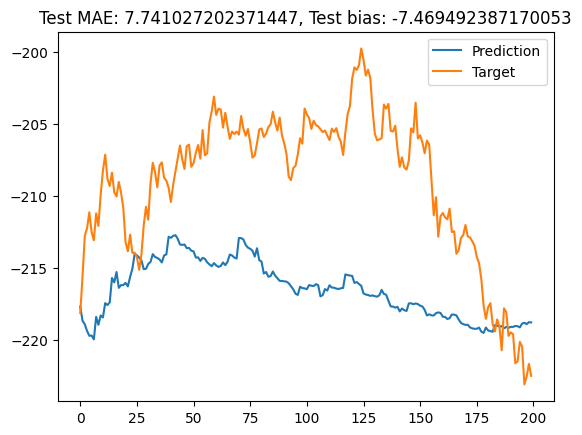

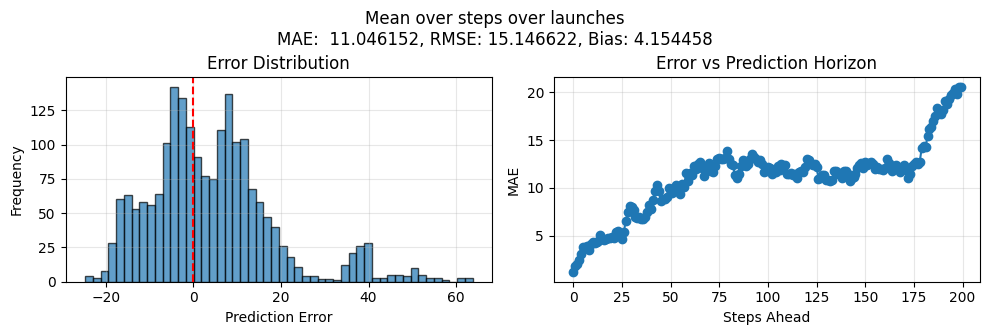

Epoch: 13
Batch IDX: 0
{'MAE': 0.8156307339668274, 'MSE': 1.2912200689315796, 'MAPE': 2.8213907033205032}
{'entropy': 1.5917466878890991, 'active': 1.0, 'means_std': 0.15969562530517578, 'stds_mean': 1.4644330739974976, 'stds_std': 0.5410048365592957, 'corr': 0.1708289086818695, 'EM weights': tensor([[0.9765, 0.9038, 1.0735, 0.9685, 0.9899, 0.9600, 0.9887, 0.9869, 1.0127,
         0.9144, 1.0248, 0.9277, 0.9656, 1.0000, 1.0512, 0.9990, 0.9951, 0.9017,
         0.9742, 1.0324, 1.0180, 0.9830, 1.0069, 1.0425, 1.0023, 1.0264, 1.0825,
         1.0079, 1.0159, 0.9501, 1.0600, 1.0370, 1.0028, 0.9436, 0.9783, 1.0120,
         0.9647, 0.9170, 0.9170, 0.9416, 1.0751, 1.0547, 0.9638, 1.0817, 0.9730,
         0.9738, 1.0350, 1.0592, 0.9779, 1.0491, 0.9528, 1.0049, 0.9293, 1.0317,
         0.9267, 0.9906, 0.9683, 0.9760, 0.9926, 1.0401, 0.9585, 0.9450, 0.9733,
         1.1478, 0.9701, 1.0167, 0.9482, 0.9940, 0.9356, 0.8951, 1.0549, 0.9863,
         0.9364, 1.0241, 1.0425, 0.9466, 0.9501, 0.8999, 1

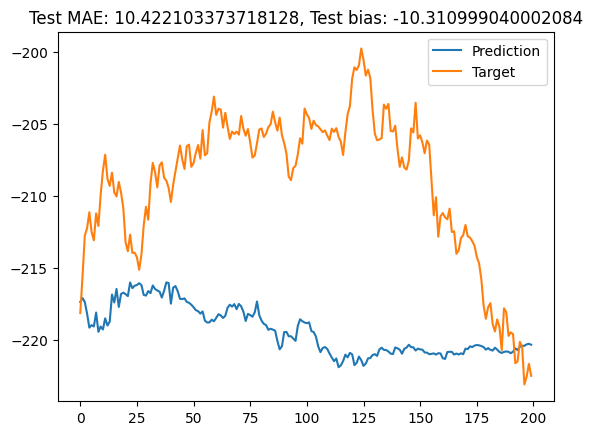

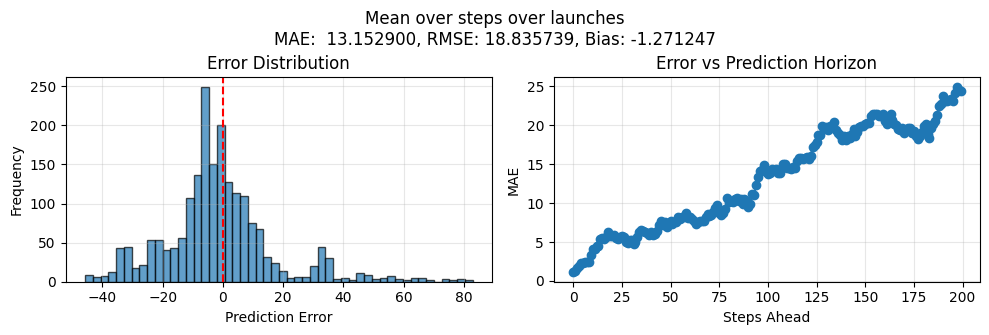

Epoch: 14
Batch IDX: 0
{'MAE': 0.8493281602859497, 'MSE': 1.130645990371704, 'MAPE': 4.578487575054169}
{'entropy': 1.5871498584747314, 'active': 1.0, 'means_std': 0.16712091863155365, 'stds_mean': 1.4767138957977295, 'stds_std': 0.49806174635887146, 'corr': -0.0012871860526502132, 'EM weights': tensor([[0.9883, 0.8910, 1.0773, 0.9846, 0.9773, 0.9540, 0.9881, 0.9904, 0.9936,
         0.9014, 1.0208, 0.9261, 0.9693, 0.9893, 1.0456, 0.9957, 1.0041, 0.9013,
         0.9769, 1.0506, 1.0377, 0.9885, 1.0105, 1.0383, 1.0005, 1.0444, 1.1003,
         1.0167, 1.0093, 0.9485, 1.0576, 1.0331, 1.0084, 0.9380, 0.9703, 1.0103,
         0.9570, 0.9046, 0.9221, 0.9365, 1.0777, 1.0511, 0.9566, 1.0886, 0.9844,
         0.9676, 1.0435, 1.0831, 0.9726, 1.0603, 0.9626, 1.0003, 0.9293, 1.0410,
         0.9210, 0.9973, 0.9667, 0.9847, 0.9761, 1.0482, 0.9602, 0.9474, 0.9670,
         1.1459, 0.9718, 1.0389, 0.9388, 0.9844, 0.9086, 0.8970, 1.0736, 0.9775,
         0.9304, 1.0291, 1.0393, 0.9516, 0.9451, 0.8937

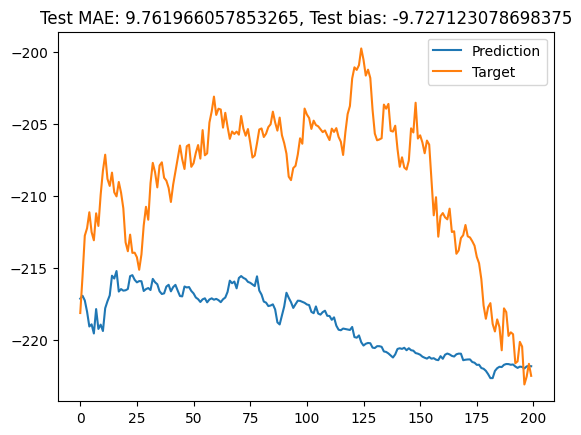

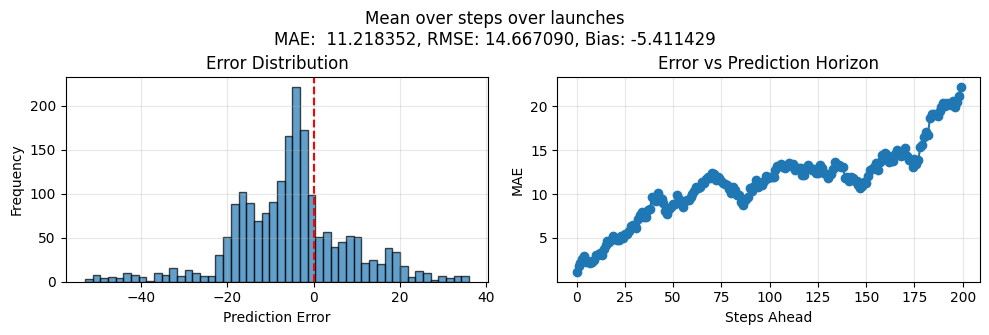

Epoch: 15
Batch IDX: 0
{'MAE': 0.7726278305053711, 'MSE': 1.0133445262908936, 'MAPE': 5.4728444665670395}
{'entropy': 1.585770606994629, 'active': 1.0, 'means_std': 0.14854124188423157, 'stds_mean': 1.4015005826950073, 'stds_std': 0.39208126068115234, 'corr': -0.0587022565305233, 'EM weights': tensor([[0.9804, 0.8881, 1.0680, 0.9863, 0.9614, 0.9471, 1.0008, 0.9794, 0.9837,
         0.8979, 1.0141, 0.9164, 0.9717, 0.9859, 1.0291, 0.9864, 1.0057, 0.9034,
         0.9793, 1.0515, 1.0411, 0.9814, 1.0059, 1.0281, 1.0055, 1.0497, 1.0976,
         1.0013, 1.0058, 0.9377, 1.0446, 1.0312, 1.0226, 0.9228, 0.9568, 1.0212,
         0.9419, 0.9163, 0.9118, 0.9339, 1.0733, 1.0584, 0.9575, 1.1001, 0.9846,
         0.9702, 1.0350, 1.0802, 0.9600, 1.0609, 0.9613, 1.0049, 0.9303, 1.0343,
         0.9125, 0.9924, 0.9689, 0.9747, 0.9708, 1.0604, 0.9687, 0.9485, 0.9660,
         1.1554, 0.9818, 1.0549, 0.9356, 0.9776, 0.9166, 0.8953, 1.0911, 0.9606,
         0.9382, 1.0358, 1.0492, 0.9554, 0.9377, 0.8904, 

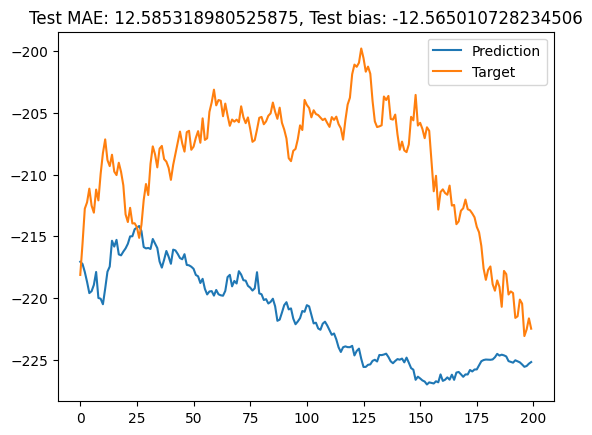

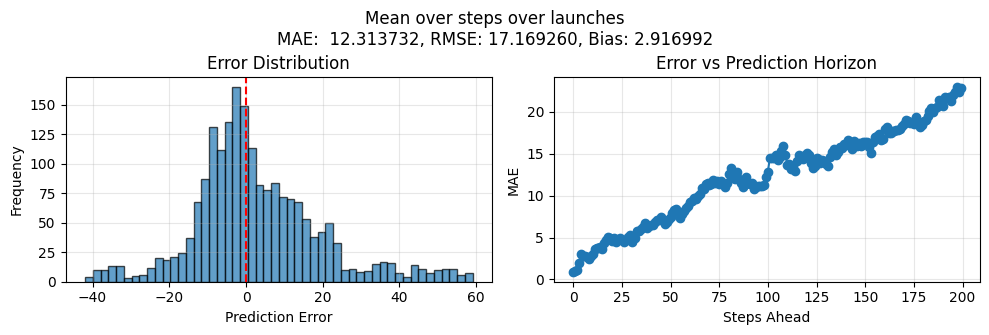

Epoch: 16
Batch IDX: 0
{'MAE': 0.8969982862472534, 'MSE': 1.343131184577942, 'MAPE': 3.391290083527565}
{'entropy': 1.5829273462295532, 'active': 1.0, 'means_std': 0.16889861226081848, 'stds_mean': 1.4777936935424805, 'stds_std': 0.4734151065349579, 'corr': 0.04923081770539284, 'EM weights': tensor([[0.9855, 0.8824, 1.0659, 0.9957, 0.9533, 0.9392, 0.9884, 0.9856, 0.9862,
         0.8991, 1.0003, 0.9142, 0.9690, 0.9864, 1.0187, 0.9909, 1.0053, 0.9025,
         0.9751, 1.0598, 1.0377, 0.9691, 1.0173, 1.0232, 1.0046, 1.0345, 1.0997,
         0.9984, 1.0108, 0.9327, 1.0350, 1.0264, 1.0092, 0.9192, 0.9401, 1.0255,
         0.9305, 0.9246, 0.9156, 0.9471, 1.0751, 1.0641, 0.9611, 1.1262, 0.9796,
         0.9711, 1.0395, 1.0912, 0.9530, 1.0553, 0.9646, 1.0074, 0.9312, 1.0386,
         0.9093, 0.9985, 0.9752, 0.9736, 0.9733, 1.0669, 0.9620, 0.9499, 0.9685,
         1.1530, 0.9873, 1.0687, 0.9381, 0.9746, 0.9207, 0.8921, 1.1016, 0.9482,
         0.9421, 1.0407, 1.0562, 0.9606, 0.9436, 0.8874, 1.

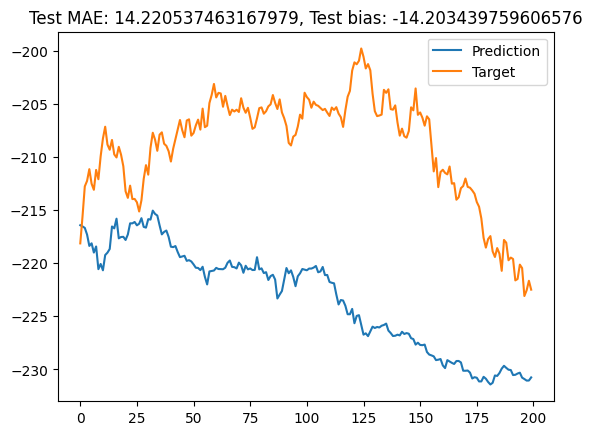

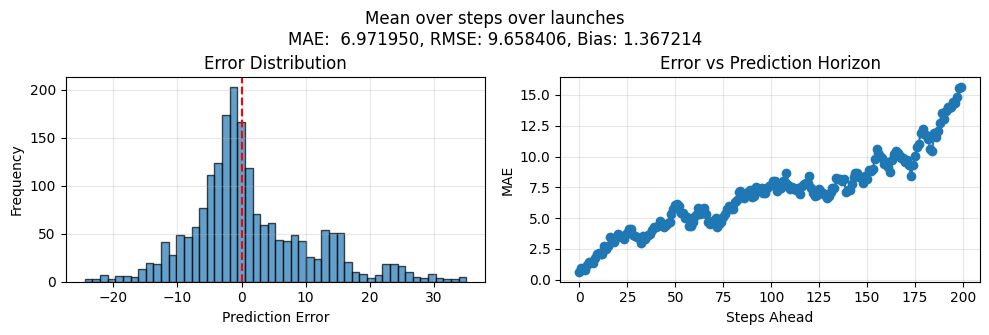

Epoch: 17
Batch IDX: 0
{'MAE': 0.7228564620018005, 'MSE': 0.9897032380104065, 'MAPE': 2.2054579108953476}
{'entropy': 1.5835119485855103, 'active': 1.0, 'means_std': 0.15801860392093658, 'stds_mean': 1.4796185493469238, 'stds_std': 0.47417113184928894, 'corr': 0.026704881340265274, 'EM weights': tensor([[0.9778, 0.8803, 1.0684, 1.0015, 0.9509, 0.9371, 0.9906, 0.9813, 0.9800,
         0.9000, 0.9976, 0.9136, 0.9681, 0.9776, 1.0146, 0.9908, 0.9904, 0.9054,
         0.9787, 1.0655, 1.0351, 0.9537, 1.0132, 1.0160, 1.0113, 1.0381, 1.1037,
         1.0099, 1.0197, 0.9301, 1.0463, 1.0232, 1.0155, 0.9087, 0.9272, 1.0330,
         0.9139, 0.9147, 0.9170, 0.9470, 1.0709, 1.0697, 0.9607, 1.1264, 0.9869,
         0.9805, 1.0481, 1.0932, 0.9505, 1.0639, 0.9571, 1.0076, 0.9313, 1.0431,
         0.8994, 1.0047, 0.9837, 0.9814, 0.9678, 1.0750, 0.9604, 0.9599, 0.9645,
         1.1608, 0.9849, 1.0819, 0.9314, 0.9592, 0.9241, 0.9006, 1.1196, 0.9398,
         0.9385, 1.0475, 1.0459, 0.9592, 0.9485, 0.8897

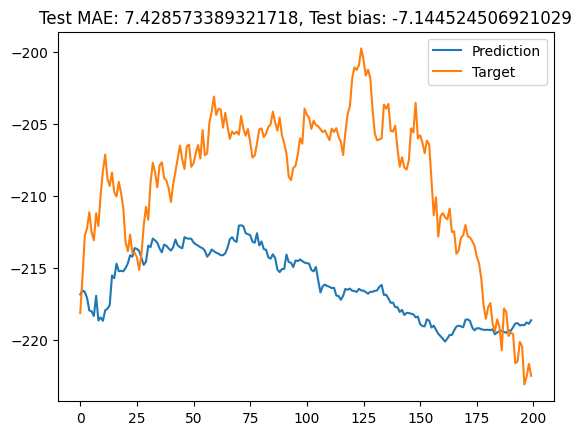

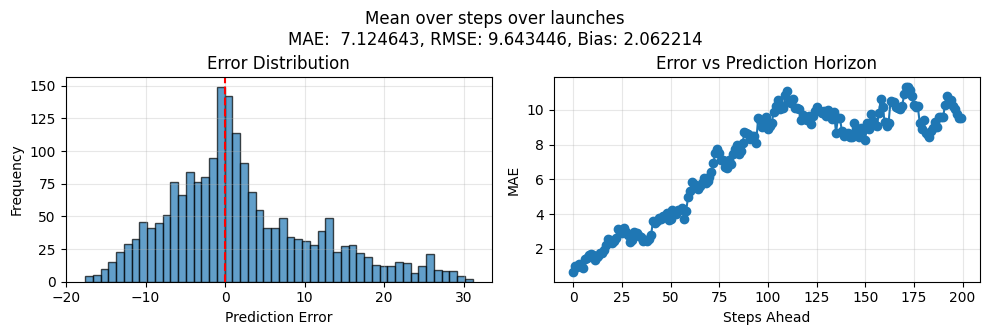

Epoch: 18
Batch IDX: 0
{'MAE': 0.6406500339508057, 'MSE': 0.7964376211166382, 'MAPE': 1.7233870923519135}
{'entropy': 1.5794826745986938, 'active': 1.0, 'means_std': 0.1826820820569992, 'stds_mean': 1.4656437635421753, 'stds_std': 0.5581373572349548, 'corr': 0.02623366378247738, 'EM weights': tensor([[0.9770, 0.8795, 1.0703, 1.0220, 0.9438, 0.9245, 0.9977, 0.9776, 0.9840,
         0.8953, 0.9966, 0.9068, 0.9629, 0.9783, 1.0032, 0.9809, 0.9967, 0.9163,
         0.9811, 1.0659, 1.0329, 0.9495, 1.0199, 1.0047, 1.0091, 1.0479, 1.1081,
         1.0038, 1.0264, 0.9249, 1.0432, 1.0268, 1.0021, 0.9023, 0.9155, 1.0347,
         0.9051, 0.9236, 0.9125, 0.9452, 1.0649, 1.0665, 0.9554, 1.1322, 0.9799,
         0.9751, 1.0568, 1.0942, 0.9384, 1.0719, 0.9573, 1.0114, 0.9275, 1.0489,
         0.9089, 1.0064, 0.9897, 0.9783, 0.9697, 1.0799, 0.9590, 0.9585, 0.9581,
         1.1628, 0.9950, 1.0970, 0.9269, 0.9529, 0.9286, 0.9008, 1.1272, 0.9359,
         0.9479, 1.0442, 1.0375, 0.9631, 0.9595, 0.8967, 1

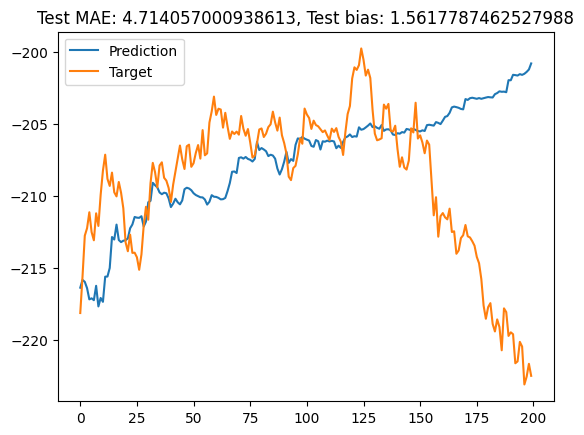

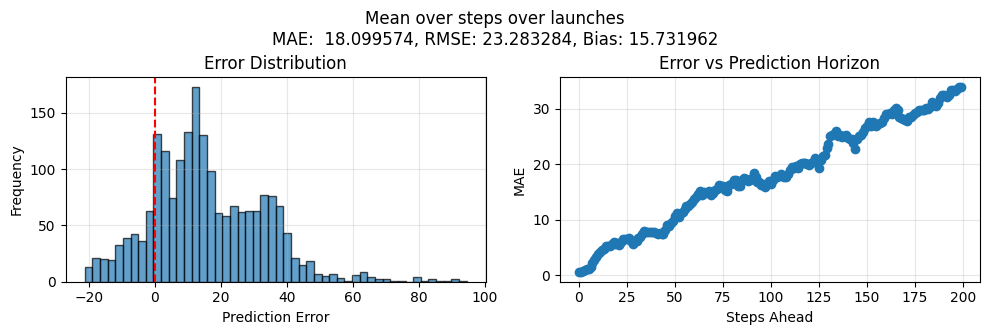

Epoch: 19
Batch IDX: 0
{'MAE': 0.6781615614891052, 'MSE': 0.7458587288856506, 'MAPE': 2.5345344096422195}
{'entropy': 1.5762039422988892, 'active': 1.0, 'means_std': 0.19876278936862946, 'stds_mean': 1.5069652795791626, 'stds_std': 0.5873467326164246, 'corr': 0.05012807250022888, 'EM weights': tensor([[0.9774, 0.8724, 1.0704, 1.0391, 0.9436, 0.9285, 1.0022, 0.9754, 0.9893,
         0.8934, 0.9932, 0.9063, 0.9658, 0.9828, 0.9925, 0.9691, 1.0049, 0.9179,
         0.9779, 1.0633, 1.0418, 0.9553, 1.0161, 1.0074, 1.0144, 1.0594, 1.1053,
         1.0057, 1.0247, 0.9196, 1.0469, 1.0347, 1.0065, 0.8937, 0.9038, 1.0252,
         0.8976, 0.9226, 0.9181, 0.9502, 1.0569, 1.0768, 0.9615, 1.1383, 0.9853,
         0.9736, 1.0585, 1.1057, 0.9354, 1.0666, 0.9527, 1.0059, 0.9187, 1.0438,
         0.9078, 1.0098, 0.9968, 0.9848, 0.9623, 1.0817, 0.9604, 0.9626, 0.9522,
         1.1801, 0.9880, 1.1106, 0.9242, 0.9443, 0.9347, 0.9016, 1.1472, 0.9306,
         0.9464, 1.0558, 1.0257, 0.9544, 0.9636, 0.8926, 

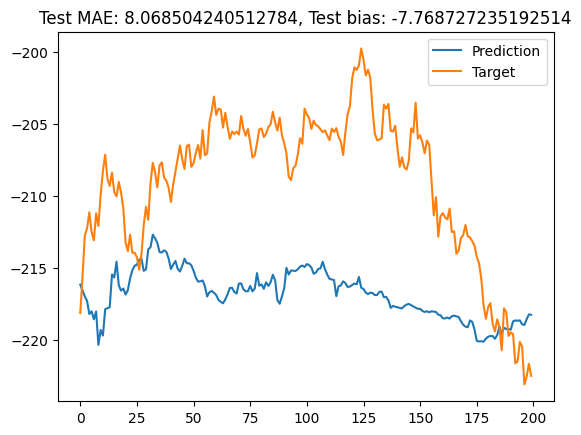

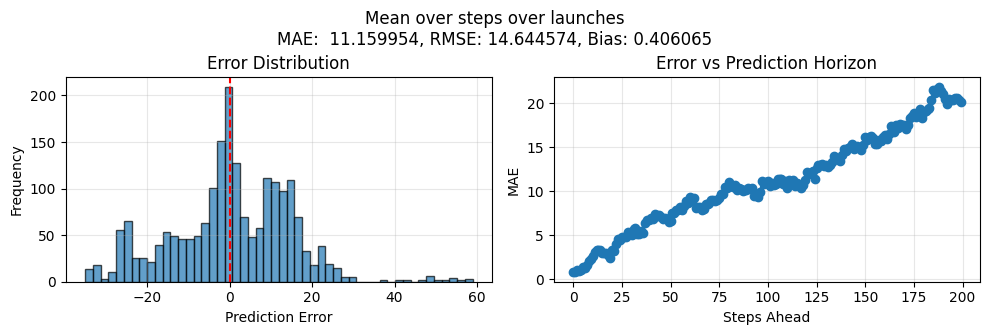

Epoch: 20
Batch IDX: 0
{'MAE': 0.6776418685913086, 'MSE': 0.6841874718666077, 'MAPE': 1.6502095386385918}
{'entropy': 1.5781782865524292, 'active': 1.0, 'means_std': 0.15691088140010834, 'stds_mean': 1.4454854726791382, 'stds_std': 0.43338966369628906, 'corr': -0.003900738898664713, 'EM weights': tensor([[0.9877, 0.8693, 1.0691, 1.0504, 0.9371, 0.9242, 0.9936, 0.9756, 1.0003,
         0.8889, 0.9991, 0.9099, 0.9679, 0.9712, 0.9800, 0.9656, 1.0161, 0.9293,
         0.9851, 1.0565, 1.0416, 0.9431, 1.0240, 0.9942, 1.0112, 1.0582, 1.1112,
         1.0218, 1.0286, 0.9160, 1.0394, 1.0441, 1.0071, 0.8803, 0.9062, 1.0289,
         0.9018, 0.9243, 0.9158, 0.9446, 1.0493, 1.0800, 0.9583, 1.1330, 0.9885,
         0.9823, 1.0577, 1.1011, 0.9271, 1.0761, 0.9449, 1.0048, 0.9178, 1.0537,
         0.9082, 1.0121, 1.0042, 0.9872, 0.9711, 1.0924, 0.9584, 0.9539, 0.9487,
         1.1790, 0.9855, 1.1197, 0.9216, 0.9376, 0.9365, 0.8970, 1.1552, 0.9300,
         0.9523, 1.0586, 1.0316, 0.9540, 0.9750, 0.906

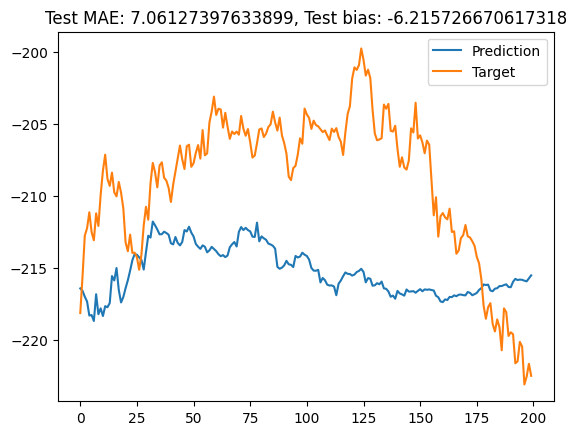

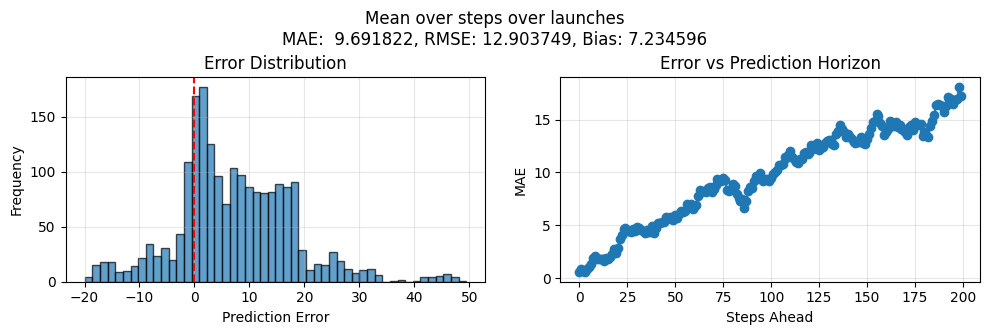

Epoch: 21
Batch IDX: 0
{'MAE': 0.651606559753418, 'MSE': 0.7791628837585449, 'MAPE': 4.634425044059753}
{'entropy': 1.5732718706130981, 'active': 1.0, 'means_std': 0.16873818635940552, 'stds_mean': 1.4151508808135986, 'stds_std': 0.5008683204650879, 'corr': 0.09187595546245575, 'EM weights': tensor([[0.9959, 0.8694, 1.0668, 1.0565, 0.9335, 0.9299, 0.9827, 0.9635, 1.0020,
         0.8895, 1.0035, 0.9067, 0.9694, 0.9644, 0.9746, 0.9520, 1.0082, 0.9343,
         0.9989, 1.0539, 1.0515, 0.9391, 1.0166, 0.9936, 1.0189, 1.0657, 1.1110,
         1.0301, 1.0262, 0.9084, 1.0365, 1.0393, 1.0075, 0.8769, 0.9065, 1.0283,
         0.8967, 0.9236, 0.9253, 0.9615, 1.0384, 1.0756, 0.9575, 1.1429, 0.9910,
         0.9922, 1.0675, 1.0966, 0.9214, 1.0782, 0.9428, 1.0011, 0.9126, 1.0532,
         0.9034, 1.0207, 1.0122, 0.9865, 0.9674, 1.0878, 0.9635, 0.9535, 0.9462,
         1.1798, 0.9820, 1.1278, 0.9123, 0.9326, 0.9372, 0.8977, 1.1595, 0.9173,
         0.9487, 1.0793, 1.0270, 0.9553, 0.9808, 0.9113, 1.

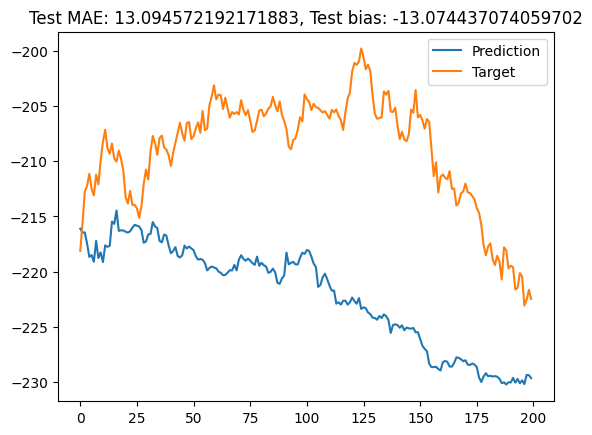

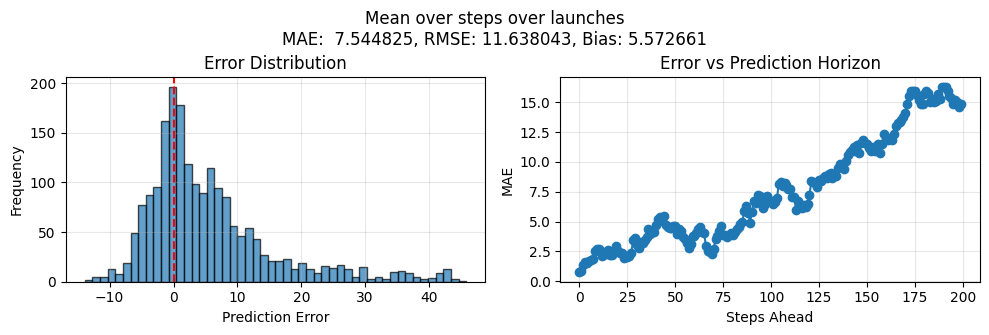

Epoch: 22
Batch IDX: 0
{'MAE': 0.5786795616149902, 'MSE': 0.5927132368087769, 'MAPE': 1.9060589373111725}
{'entropy': 1.5729764699935913, 'active': 1.0, 'means_std': 0.20021791756153107, 'stds_mean': 1.441327452659607, 'stds_std': 0.5276421904563904, 'corr': 0.016375603154301643, 'EM weights': tensor([[1.0052, 0.8589, 1.0683, 1.0670, 0.9307, 0.9308, 0.9776, 0.9673, 1.0113,
         0.8959, 0.9956, 0.9041, 0.9661, 0.9627, 0.9665, 0.9419, 1.0080, 0.9332,
         0.9988, 1.0527, 1.0510, 0.9324, 1.0227, 0.9876, 1.0227, 1.0655, 1.1121,
         1.0351, 1.0304, 0.9049, 1.0354, 1.0466, 1.0015, 0.8709, 0.8965, 1.0442,
         0.9006, 0.9233, 0.9213, 0.9703, 1.0378, 1.0719, 0.9596, 1.1434, 0.9943,
         0.9993, 1.0657, 1.1056, 0.9114, 1.0867, 0.9493, 0.9984, 0.9068, 1.0545,
         0.8991, 1.0255, 1.0225, 0.9844, 0.9722, 1.0905, 0.9590, 0.9507, 0.9427,
         1.1902, 0.9780, 1.1271, 0.9114, 0.9350, 0.9398, 0.9075, 1.1592, 0.9141,
         0.9517, 1.0764, 1.0300, 0.9559, 0.9877, 0.9124, 

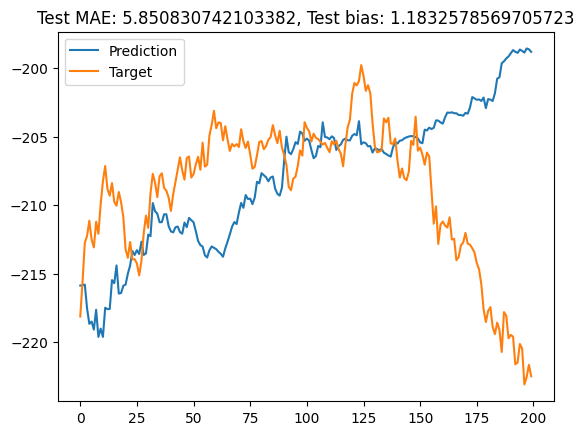

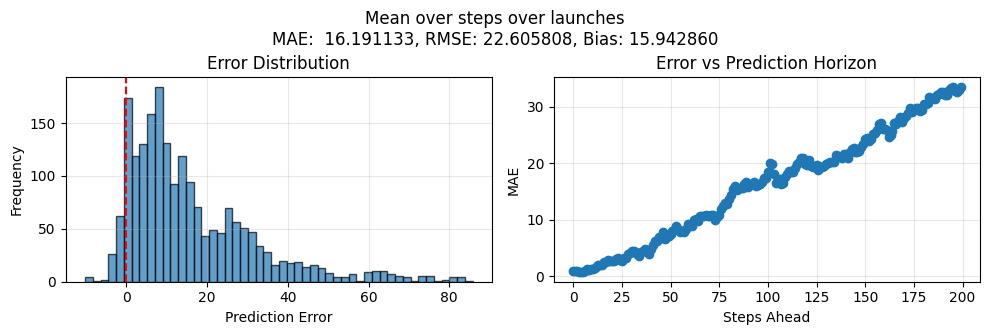

Epoch: 23
Batch IDX: 0
{'MAE': 0.5285346508026123, 'MSE': 0.45754528045654297, 'MAPE': 2.00685802847147}
{'entropy': 1.5701042413711548, 'active': 1.0, 'means_std': 0.17536614835262299, 'stds_mean': 1.3786933422088623, 'stds_std': 0.42974478006362915, 'corr': -0.0009165398660115898, 'EM weights': tensor([[1.0009, 0.8600, 1.0738, 1.0650, 0.9279, 0.9253, 0.9695, 0.9696, 0.9991,
         0.8999, 0.9943, 0.9042, 0.9635, 0.9533, 0.9565, 0.9476, 1.0114, 0.9319,
         0.9996, 1.0594, 1.0576, 0.9343, 1.0225, 0.9821, 1.0239, 1.0732, 1.1135,
         1.0423, 1.0320, 0.9017, 1.0275, 1.0404, 1.0028, 0.8591, 0.8887, 1.0538,
         0.8893, 0.9230, 0.9220, 0.9672, 1.0258, 1.0646, 0.9686, 1.1379, 0.9877,
         1.0027, 1.0781, 1.1089, 0.9038, 1.0841, 0.9450, 0.9929, 0.9037, 1.0535,
         0.8945, 1.0212, 1.0310, 0.9779, 0.9603, 1.1057, 0.9677, 0.9566, 0.9336,
         1.1863, 0.9702, 1.1334, 0.9118, 0.9387, 0.9469, 0.9111, 1.1730, 0.9201,
         0.9513, 1.0802, 1.0307, 0.9462, 0.9904, 0.922

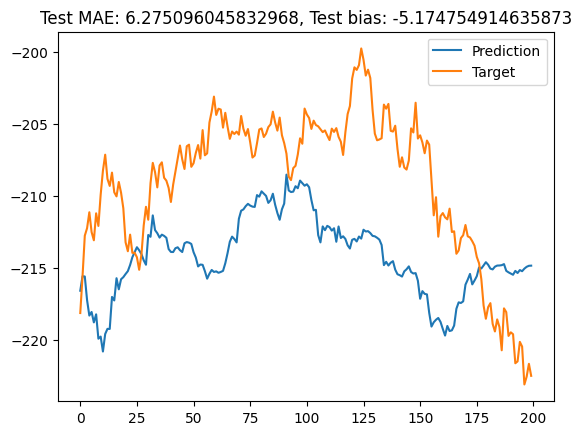

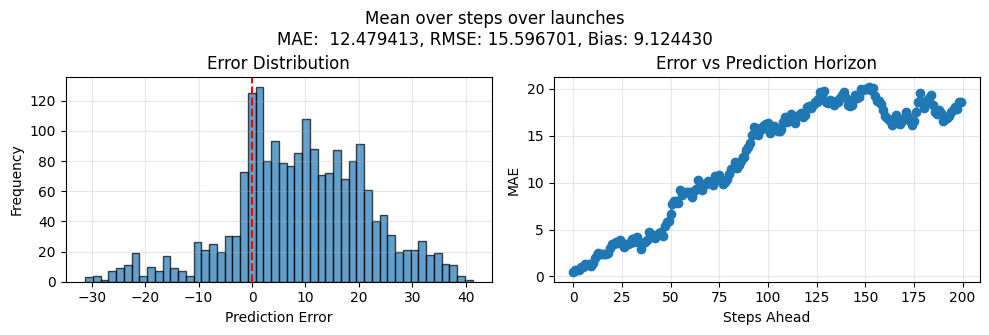

Epoch: 24
Batch IDX: 0
{'MAE': 0.5863423943519592, 'MSE': 0.6289863586425781, 'MAPE': 3.2305873930454254}
{'entropy': 1.5683790445327759, 'active': 1.0, 'means_std': 0.17951269447803497, 'stds_mean': 1.425704836845398, 'stds_std': 0.445818156003952, 'corr': 0.04238465800881386, 'EM weights': tensor([[1.0105, 0.8523, 1.0761, 1.0663, 0.9199, 0.9241, 0.9705, 0.9696, 1.0065,
         0.8932, 0.9942, 0.9071, 0.9609, 0.9490, 0.9427, 0.9413, 1.0122, 0.9314,
         1.0035, 1.0556, 1.0548, 0.9304, 1.0192, 0.9790, 1.0232, 1.0758, 1.1178,
         1.0475, 1.0324, 0.9024, 1.0248, 1.0359, 1.0033, 0.8553, 0.8765, 1.0474,
         0.8854, 0.9177, 0.9195, 0.9685, 1.0242, 1.0747, 0.9656, 1.1306, 0.9854,
         1.0101, 1.0771, 1.1031, 0.8994, 1.0846, 0.9446, 0.9898, 0.9006, 1.0543,
         0.8935, 1.0288, 1.0380, 0.9809, 0.9654, 1.1040, 0.9679, 0.9595, 0.9308,
         1.1850, 0.9764, 1.1376, 0.9156, 0.9308, 0.9517, 0.9175, 1.1688, 0.9200,
         0.9503, 1.0788, 1.0314, 0.9464, 1.0025, 0.9212, 1.

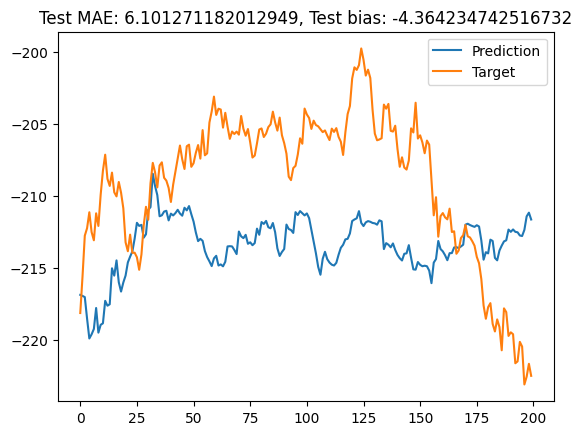

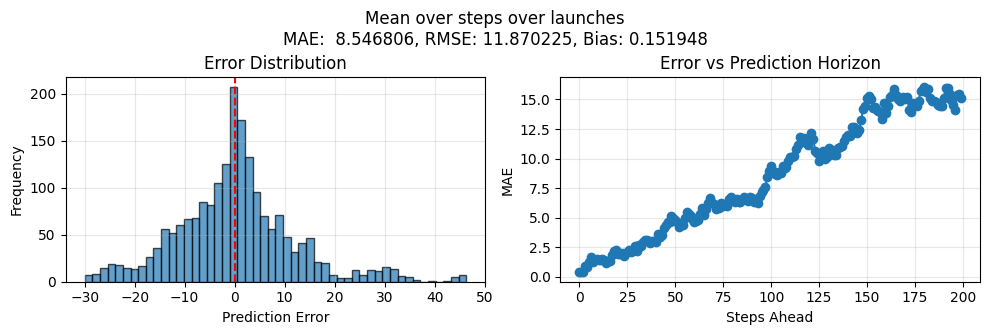

Epoch: 25
Batch IDX: 0
{'MAE': 0.6019182205200195, 'MSE': 0.6685327291488647, 'MAPE': 2.2134454920887947}
{'entropy': 1.5684765577316284, 'active': 1.0, 'means_std': 0.17964401841163635, 'stds_mean': 1.473824381828308, 'stds_std': 0.48492667078971863, 'corr': -0.08361943811178207, 'EM weights': tensor([[1.0167, 0.8497, 1.0751, 1.0516, 0.9220, 0.9174, 0.9621, 0.9658, 1.0187,
         0.8963, 0.9864, 0.9072, 0.9613, 0.9500, 0.9347, 0.9344, 1.0165, 0.9346,
         1.0040, 1.0487, 1.0589, 0.9283, 1.0169, 0.9725, 1.0151, 1.0796, 1.1128,
         1.0514, 1.0335, 0.9005, 1.0191, 1.0346, 1.0020, 0.8542, 0.8719, 1.0440,
         0.8839, 0.9181, 0.9180, 0.9619, 1.0141, 1.0762, 0.9680, 1.1285, 0.9849,
         1.0156, 1.0808, 1.1073, 0.8981, 1.0874, 0.9378, 0.9877, 0.9037, 1.0553,
         0.8874, 1.0292, 1.0520, 0.9863, 0.9680, 1.1043, 0.9676, 0.9641, 0.9177,
         1.1862, 0.9760, 1.1390, 0.9134, 0.9255, 0.9557, 0.9188, 1.1741, 0.9184,
         0.9520, 1.0870, 1.0318, 0.9512, 1.0052, 0.9313,

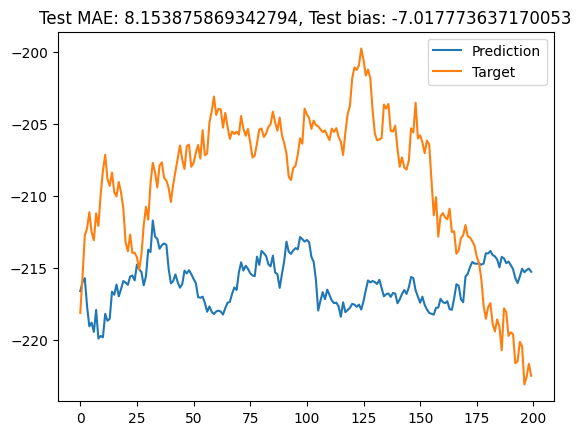

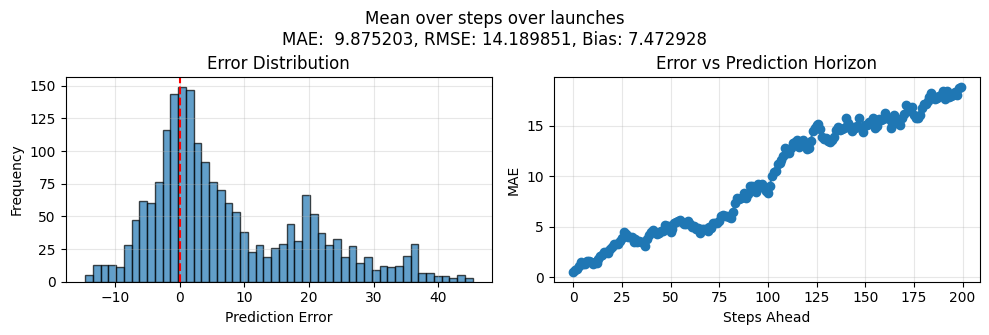

Epoch: 26
Batch IDX: 0
{'MAE': 0.4928555488586426, 'MSE': 0.4272615909576416, 'MAPE': 1.5699587762355804}
{'entropy': 1.566367268562317, 'active': 1.0, 'means_std': 0.18113917112350464, 'stds_mean': 1.4231971502304077, 'stds_std': 0.44898709654808044, 'corr': -0.029610758647322655, 'EM weights': tensor([[1.0177, 0.8473, 1.0776, 1.0580, 0.9232, 0.9161, 0.9652, 0.9590, 1.0298,
         0.8916, 0.9886, 0.9110, 0.9592, 0.9481, 0.9318, 0.9320, 1.0181, 0.9361,
         1.0047, 1.0493, 1.0610, 0.9250, 1.0179, 0.9691, 1.0133, 1.0861, 1.1161,
         1.0590, 1.0360, 0.9011, 1.0129, 1.0314, 1.0035, 0.8457, 0.8695, 1.0404,
         0.8831, 0.9149, 0.9176, 0.9630, 0.9983, 1.0778, 0.9669, 1.1275, 0.9803,
         1.0175, 1.0848, 1.1071, 0.8985, 1.0923, 0.9302, 0.9871, 0.9034, 1.0525,
         0.8887, 1.0227, 1.0633, 0.9826, 0.9696, 1.1031, 0.9690, 0.9577, 0.9092,
         1.1858, 0.9737, 1.1380, 0.9141, 0.9222, 0.9616, 0.9138, 1.1804, 0.9214,
         0.9536, 1.0885, 1.0335, 0.9476, 1.0089, 0.9224

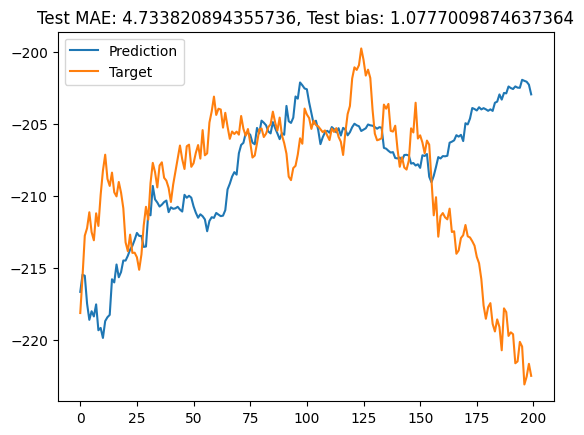

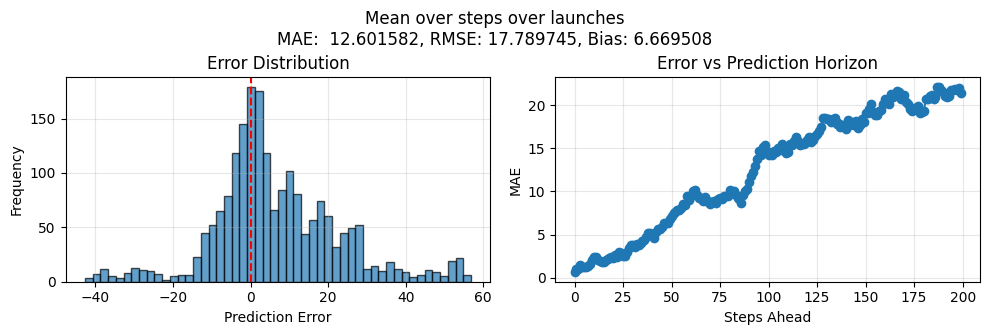

Epoch: 27
Batch IDX: 0
{'MAE': 0.5313807129859924, 'MSE': 0.5049107074737549, 'MAPE': 1.7577700316905975}
{'entropy': 1.5676466226577759, 'active': 1.0, 'means_std': 0.16797706484794617, 'stds_mean': 1.4364352226257324, 'stds_std': 0.4974678158760071, 'corr': -0.01829872652888298, 'EM weights': tensor([[1.0252, 0.8394, 1.0747, 1.0576, 0.9305, 0.9126, 0.9641, 0.9552, 1.0258,
         0.8910, 0.9858, 0.9087, 0.9540, 0.9517, 0.9245, 0.9283, 1.0204, 0.9365,
         1.0083, 1.0444, 1.0619, 0.9227, 1.0151, 0.9663, 1.0138, 1.0910, 1.1126,
         1.0655, 1.0398, 0.9002, 1.0161, 1.0320, 1.0094, 0.8418, 0.8617, 1.0395,
         0.8833, 0.9167, 0.9167, 0.9643, 0.9953, 1.0809, 0.9668, 1.1245, 0.9866,
         1.0201, 1.0923, 1.1090, 0.8967, 1.0993, 0.9347, 0.9836, 0.9003, 1.0515,
         0.8860, 1.0269, 1.0679, 0.9774, 0.9725, 1.1038, 0.9678, 0.9571, 0.9020,
         1.1786, 0.9689, 1.1381, 0.9134, 0.9161, 0.9652, 0.9213, 1.1782, 0.9259,
         0.9600, 1.0953, 1.0451, 0.9502, 1.0156, 0.9250,

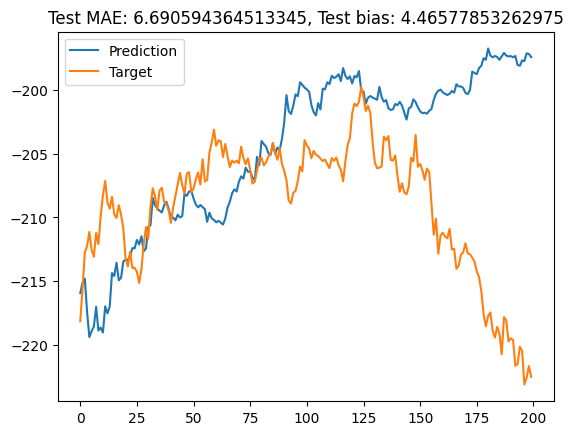

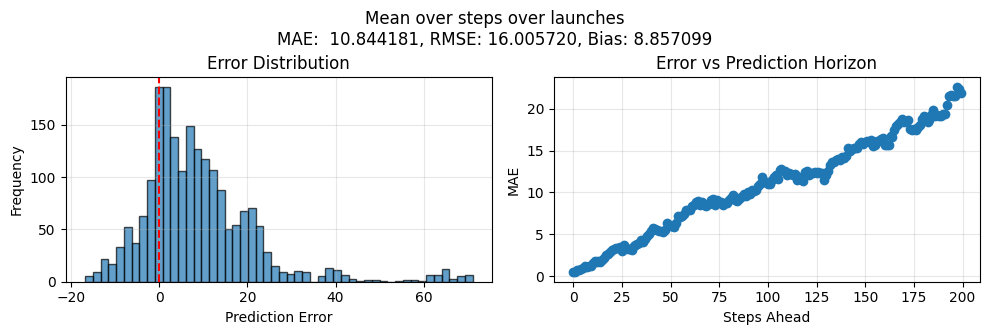

Epoch: 28
Batch IDX: 0
{'MAE': 0.4720478057861328, 'MSE': 0.3951374590396881, 'MAPE': 1.4782112091779709}
{'entropy': 1.561482548713684, 'active': 1.0, 'means_std': 0.19406969845294952, 'stds_mean': 1.4799145460128784, 'stds_std': 0.4675319790840149, 'corr': 0.008022970519959927, 'EM weights': tensor([[1.0310, 0.8378, 1.0732, 1.0491, 0.9279, 0.9184, 0.9656, 0.9593, 1.0325,
         0.8918, 0.9897, 0.9042, 0.9514, 0.9577, 0.9220, 0.9242, 1.0177, 0.9323,
         1.0043, 1.0438, 1.0664, 0.9181, 1.0161, 0.9621, 1.0196, 1.1008, 1.1141,
         1.0674, 1.0440, 0.8988, 1.0115, 1.0261, 1.0058, 0.8342, 0.8620, 1.0472,
         0.8800, 0.9130, 0.9182, 0.9596, 0.9882, 1.0723, 0.9688, 1.1146, 0.9877,
         1.0294, 1.0931, 1.1077, 0.8863, 1.1006, 0.9371, 0.9851, 0.9034, 1.0509,
         0.8835, 1.0281, 1.0732, 0.9804, 0.9704, 1.1011, 0.9712, 0.9657, 0.8974,
         1.1799, 0.9692, 1.1392, 0.9148, 0.9118, 0.9720, 0.9215, 1.1785, 0.9288,
         0.9631, 1.1031, 1.0383, 0.9523, 1.0175, 0.9203, 

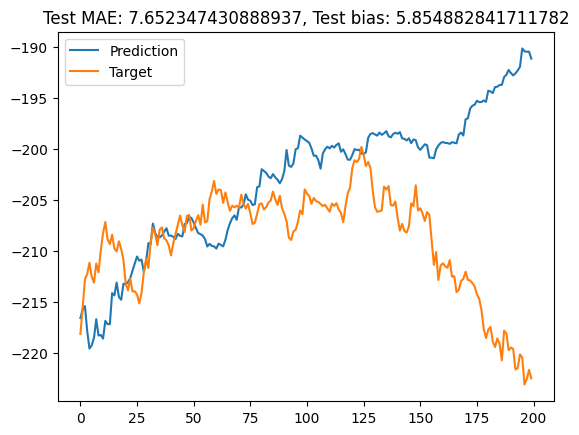

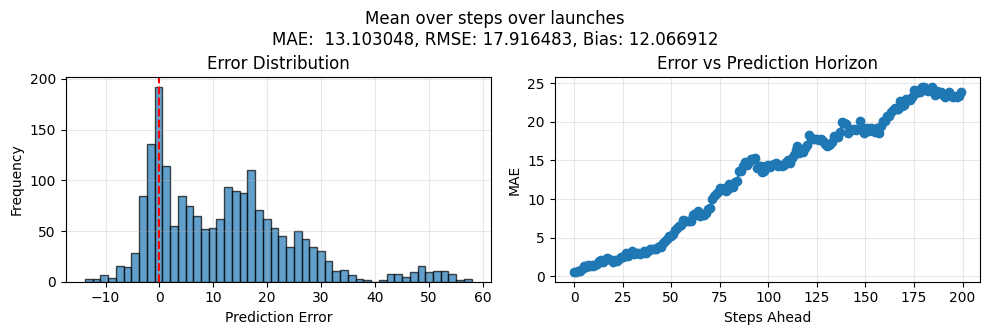

Epoch: 29
Batch IDX: 0
{'MAE': 0.5060280561447144, 'MSE': 0.4411948323249817, 'MAPE': 5.705436319112778}
{'entropy': 1.5616446733474731, 'active': 1.0, 'means_std': 0.18805710971355438, 'stds_mean': 1.3884309530258179, 'stds_std': 0.4524599611759186, 'corr': -0.04345543310046196, 'EM weights': tensor([[1.0343, 0.8375, 1.0700, 1.0407, 0.9254, 0.9201, 0.9642, 0.9566, 1.0320,
         0.8954, 0.9877, 0.9048, 0.9526, 0.9546, 0.9145, 0.9240, 1.0170, 0.9334,
         0.9986, 1.0436, 1.0644, 0.9160, 1.0183, 0.9633, 1.0195, 1.1014, 1.1190,
         1.0647, 1.0447, 0.8978, 1.0091, 1.0286, 1.0069, 0.8224, 0.8586, 1.0477,
         0.8819, 0.9128, 0.9226, 0.9563, 0.9849, 1.0684, 0.9632, 1.1158, 0.9848,
         1.0368, 1.0926, 1.1071, 0.8856, 1.1001, 0.9341, 0.9802, 0.9028, 1.0553,
         0.8810, 1.0225, 1.0803, 0.9798, 0.9728, 1.1044, 0.9700, 0.9643, 0.8890,
         1.1823, 0.9687, 1.1324, 0.9123, 0.9158, 0.9756, 0.9265, 1.1789, 0.9352,
         0.9730, 1.1049, 1.0370, 0.9516, 1.0175, 0.9222, 

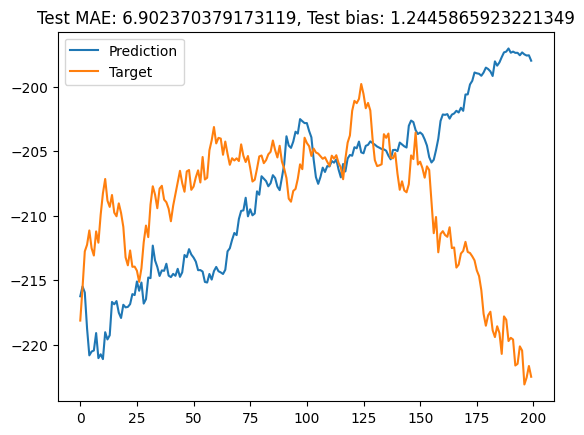

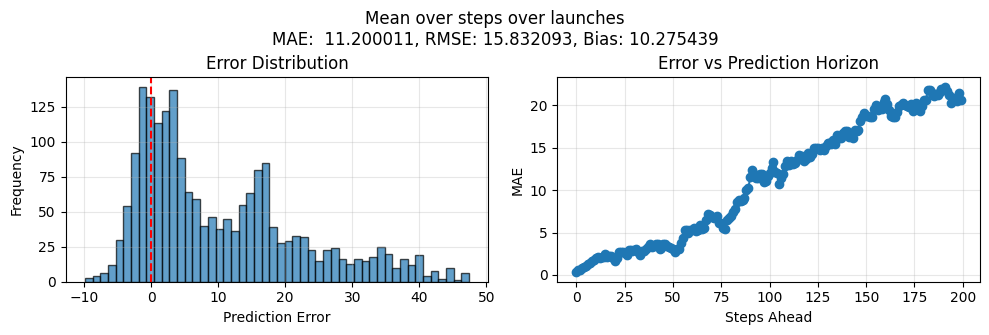

Epoch: 30
Batch IDX: 0
{'MAE': 0.4401814639568329, 'MSE': 0.3119489252567291, 'MAPE': 1.8467200919985771}
{'entropy': 1.563988208770752, 'active': 1.0, 'means_std': 0.1847754865884781, 'stds_mean': 1.4762020111083984, 'stds_std': 0.503506064414978, 'corr': 0.008598370477557182, 'EM weights': tensor([[1.0393, 0.8350, 1.0706, 1.0441, 0.9275, 0.9209, 0.9587, 0.9550, 1.0421,
         0.9000, 0.9910, 0.9014, 0.9504, 0.9567, 0.9147, 0.9239, 1.0246, 0.9288,
         0.9974, 1.0317, 1.0678, 0.9075, 1.0182, 0.9620, 1.0208, 1.1031, 1.1197,
         1.0731, 1.0428, 0.8946, 1.0039, 1.0287, 1.0043, 0.8224, 0.8554, 1.0484,
         0.8770, 0.9094, 0.9252, 0.9524, 0.9805, 1.0716, 0.9658, 1.1099, 0.9798,
         1.0365, 1.0957, 1.1067, 0.8834, 1.0987, 0.9392, 0.9795, 0.8992, 1.0526,
         0.8803, 1.0198, 1.0836, 0.9760, 0.9637, 1.1050, 0.9694, 0.9681, 0.8875,
         1.1826, 0.9670, 1.1330, 0.9109, 0.9187, 0.9804, 0.9234, 1.1832, 0.9365,
         0.9752, 1.1043, 1.0385, 0.9528, 1.0229, 0.9190, 0.

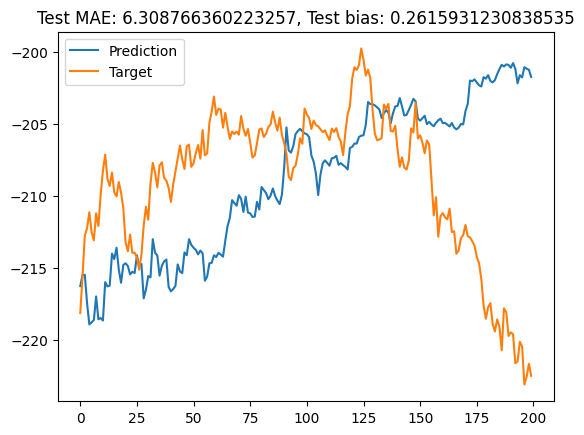

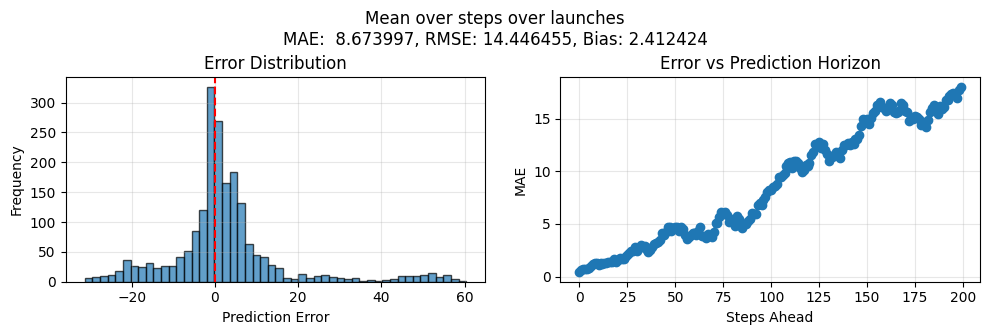

Epoch: 31
Batch IDX: 0
{'MAE': 0.40553098917007446, 'MSE': 0.29760003089904785, 'MAPE': 1.4872879721224308}
{'entropy': 1.5575765371322632, 'active': 1.0, 'means_std': 0.1855810135602951, 'stds_mean': 1.4273170232772827, 'stds_std': 0.46225643157958984, 'corr': 0.039215050637722015, 'EM weights': tensor([[1.0442, 0.8364, 1.0724, 1.0363, 0.9316, 0.9189, 0.9594, 0.9555, 1.0446,
         0.8984, 0.9927, 0.8988, 0.9497, 0.9540, 0.9091, 0.9212, 1.0269, 0.9309,
         0.9960, 1.0311, 1.0742, 0.9079, 1.0219, 0.9597, 1.0253, 1.1047, 1.1196,
         1.0806, 1.0459, 0.8885, 1.0112, 1.0195, 1.0046, 0.8125, 0.8529, 1.0429,
         0.8784, 0.9079, 0.9266, 0.9550, 0.9739, 1.0747, 0.9599, 1.1062, 0.9817,
         1.0430, 1.1018, 1.1089, 0.8793, 1.1012, 0.9352, 0.9766, 0.8977, 1.0560,
         0.8756, 1.0185, 1.0912, 0.9767, 0.9656, 1.1077, 0.9665, 0.9635, 0.8824,
         1.1790, 0.9676, 1.1294, 0.9112, 0.9202, 0.9756, 0.9310, 1.1818, 0.9380,
         0.9749, 1.1043, 1.0348, 0.9560, 1.0257, 0.924

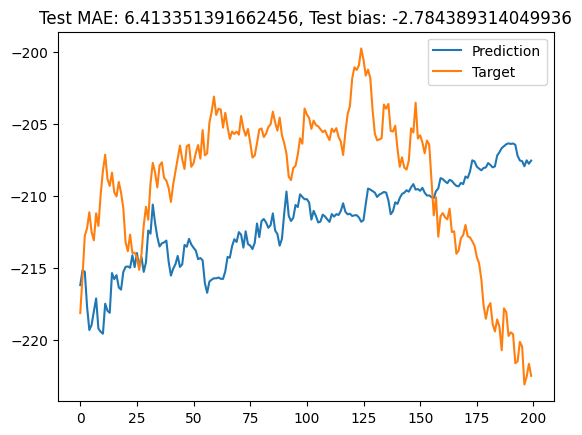

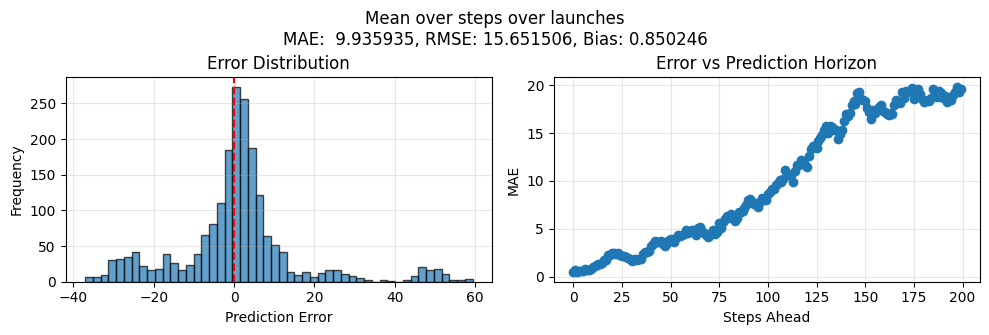

Epoch: 32
Batch IDX: 0
{'MAE': 0.48546314239501953, 'MSE': 0.39993464946746826, 'MAPE': 0.9799497202038765}
{'entropy': 1.5582202672958374, 'active': 1.0, 'means_std': 0.21935950219631195, 'stds_mean': 1.4749281406402588, 'stds_std': 0.5346769690513611, 'corr': 0.03710974007844925, 'EM weights': tensor([[1.0454, 0.8358, 1.0719, 1.0373, 0.9266, 0.9152, 0.9583, 0.9556, 1.0513,
         0.8987, 0.9965, 0.8961, 0.9516, 0.9501, 0.9093, 0.9211, 1.0230, 0.9305,
         0.9897, 1.0259, 1.0749, 0.9051, 1.0234, 0.9579, 1.0267, 1.1128, 1.1203,
         1.0817, 1.0451, 0.8863, 1.0069, 1.0169, 1.0091, 0.8073, 0.8483, 1.0418,
         0.8771, 0.9110, 0.9278, 0.9514, 0.9681, 1.0709, 0.9619, 1.0978, 0.9824,
         1.0472, 1.1003, 1.1136, 0.8786, 1.0987, 0.9393, 0.9703, 0.8971, 1.0518,
         0.8719, 1.0161, 1.0925, 0.9773, 0.9629, 1.1079, 0.9678, 0.9689, 0.8774,
         1.1767, 0.9633, 1.1277, 0.9110, 0.9266, 0.9759, 0.9255, 1.1884, 0.9438,
         0.9830, 1.1051, 1.0372, 0.9519, 1.0299, 0.9204

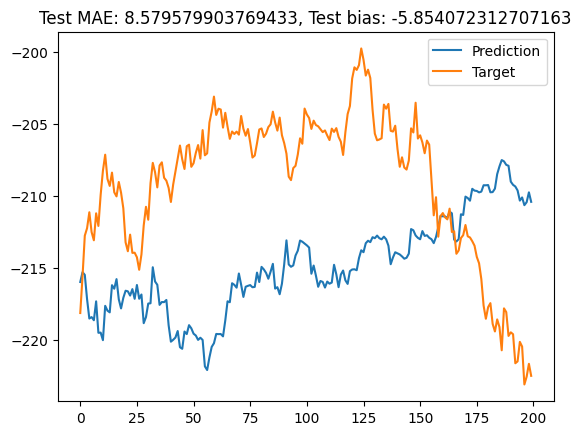

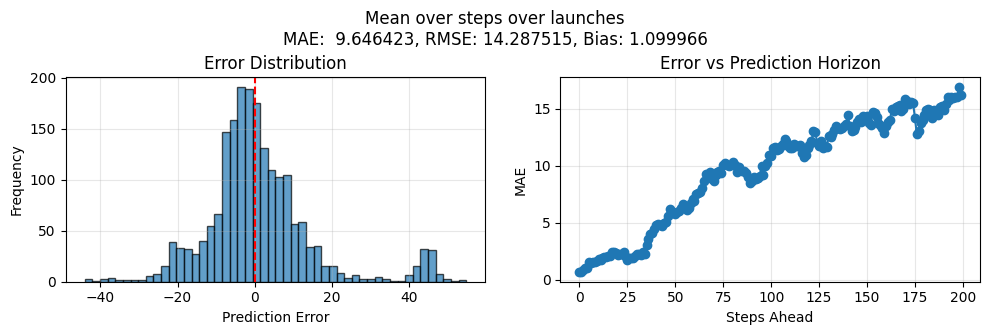

Epoch: 33
Batch IDX: 0
{'MAE': 0.43966764211654663, 'MSE': 0.4394150972366333, 'MAPE': 1.9100934267044067}
{'entropy': 1.5606733560562134, 'active': 1.0, 'means_std': 0.1804925501346588, 'stds_mean': 1.413728952407837, 'stds_std': 0.4347970485687256, 'corr': -0.017537454143166542, 'EM weights': tensor([[1.0495, 0.8334, 1.0732, 1.0336, 0.9264, 0.9172, 0.9590, 0.9594, 1.0555,
         0.9007, 0.9965, 0.8939, 0.9476, 0.9513, 0.9077, 0.9195, 1.0217, 0.9300,
         0.9875, 1.0197, 1.0754, 0.9038, 1.0287, 0.9594, 1.0282, 1.1077, 1.1199,
         1.0870, 1.0451, 0.8876, 1.0085, 1.0137, 1.0119, 0.7951, 0.8464, 1.0370,
         0.8820, 0.9064, 0.9264, 0.9500, 0.9630, 1.0780, 0.9558, 1.0904, 0.9854,
         1.0442, 1.1028, 1.1114, 0.8800, 1.0999, 0.9394, 0.9686, 0.8987, 1.0583,
         0.8706, 1.0108, 1.0960, 0.9787, 0.9625, 1.1124, 0.9684, 0.9636, 0.8747,
         1.1722, 0.9645, 1.1296, 0.9112, 0.9258, 0.9775, 0.9259, 1.1907, 0.9457,
         0.9870, 1.1127, 1.0385, 0.9562, 1.0313, 0.9210,

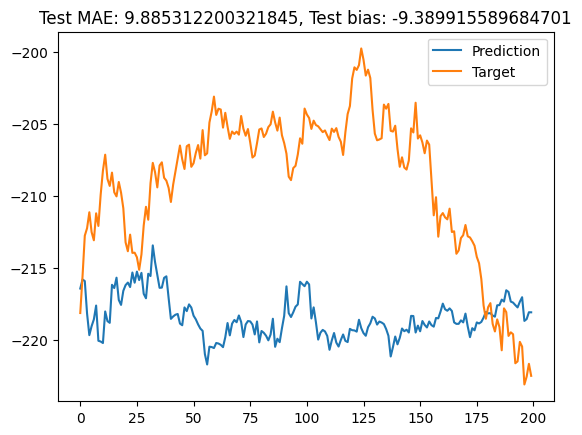

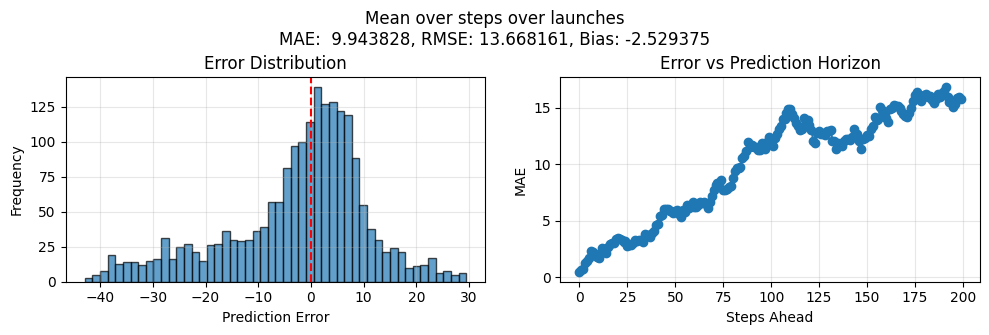

Epoch: 34
Batch IDX: 0
{'MAE': 0.394203245639801, 'MSE': 0.26040348410606384, 'MAPE': 2.109171077609062}
{'entropy': 1.5559697151184082, 'active': 1.0, 'means_std': 0.16669344902038574, 'stds_mean': 1.367256760597229, 'stds_std': 0.451108455657959, 'corr': 0.00615266989916563, 'EM weights': tensor([[1.0568, 0.8328, 1.0711, 1.0332, 0.9292, 0.9166, 0.9554, 0.9619, 1.0547,
         0.9019, 0.9995, 0.8935, 0.9463, 0.9496, 0.9031, 0.9200, 1.0165, 0.9318,
         0.9832, 1.0196, 1.0755, 0.8966, 1.0287, 0.9614, 1.0262, 1.1102, 1.1210,
         1.0852, 1.0469, 0.8804, 1.0116, 1.0158, 1.0168, 0.7936, 0.8455, 1.0314,
         0.8763, 0.9051, 0.9264, 0.9473, 0.9580, 1.0749, 0.9586, 1.0860, 0.9883,
         1.0462, 1.1081, 1.1181, 0.8771, 1.1014, 0.9409, 0.9642, 0.8936, 1.0572,
         0.8693, 1.0083, 1.0974, 0.9831, 0.9583, 1.1130, 0.9693, 0.9662, 0.8677,
         1.1710, 0.9627, 1.1284, 0.9107, 0.9243, 0.9771, 0.9317, 1.1891, 0.9500,
         0.9944, 1.1129, 1.0450, 0.9553, 1.0379, 0.9214, 0.9

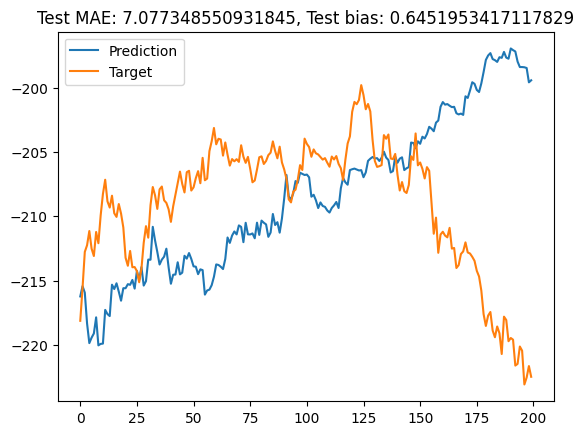

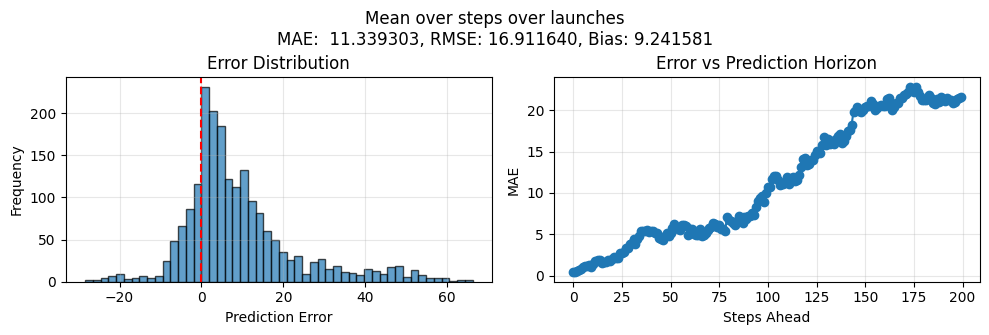

Epoch: 35
Batch IDX: 0
{'MAE': 0.3785916566848755, 'MSE': 0.2544025778770447, 'MAPE': 1.9914180040359497}
{'entropy': 1.5560650825500488, 'active': 0.9984375238418579, 'means_std': 0.19672535359859467, 'stds_mean': 1.4395650625228882, 'stds_std': 0.5330473184585571, 'corr': 0.012814377434551716, 'EM weights': tensor([[1.0555, 0.8353, 1.0700, 1.0349, 0.9288, 0.9181, 0.9509, 0.9609, 1.0566,
         0.9008, 0.9958, 0.8977, 0.9471, 0.9495, 0.9019, 0.9196, 1.0201, 0.9318,
         0.9799, 1.0157, 1.0788, 0.8917, 1.0306, 0.9586, 1.0299, 1.1126, 1.1207,
         1.0880, 1.0463, 0.8766, 1.0092, 1.0051, 1.0147, 0.7879, 0.8447, 1.0289,
         0.8778, 0.9023, 0.9296, 0.9455, 0.9596, 1.0778, 0.9548, 1.0861, 0.9846,
         1.0478, 1.1109, 1.1172, 0.8809, 1.0974, 0.9398, 0.9649, 0.8955, 1.0582,
         0.8657, 1.0056, 1.1025, 0.9857, 0.9556, 1.1118, 0.9695, 0.9674, 0.8619,
         1.1709, 0.9596, 1.1282, 0.9091, 0.9266, 0.9740, 0.9318, 1.1978, 0.9495,
         0.9985, 1.1090, 1.0430, 0.9559, 

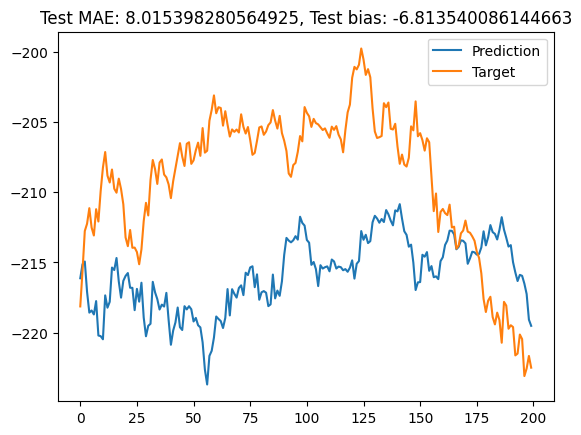

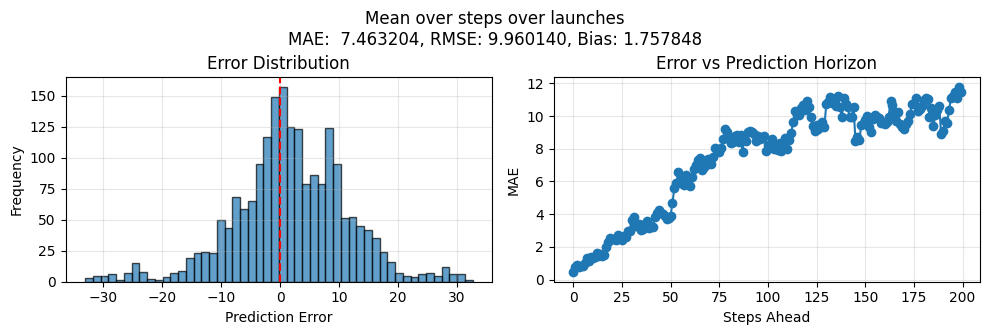

Epoch: 36
Batch IDX: 0
{'MAE': 0.43743520975112915, 'MSE': 0.40535295009613037, 'MAPE': 1.2456917203962803}
{'entropy': 1.5546263456344604, 'active': 1.0, 'means_std': 0.1972910463809967, 'stds_mean': 1.397745966911316, 'stds_std': 0.5094050168991089, 'corr': 0.06008848175406456, 'EM weights': tensor([[1.0543, 0.8333, 1.0715, 1.0337, 0.9323, 0.9184, 0.9489, 0.9607, 1.0595,
         0.9024, 0.9965, 0.8988, 0.9454, 0.9462, 0.9015, 0.9198, 1.0172, 0.9309,
         0.9743, 1.0107, 1.0792, 0.8930, 1.0335, 0.9609, 1.0307, 1.1155, 1.1234,
         1.0885, 1.0488, 0.8715, 1.0044, 1.0068, 1.0149, 0.7828, 0.8435, 1.0275,
         0.8785, 0.8999, 0.9296, 0.9458, 0.9579, 1.0740, 0.9560, 1.0828, 0.9870,
         1.0496, 1.1105, 1.1143, 0.8779, 1.0960, 0.9440, 0.9622, 0.8916, 1.0560,
         0.8657, 1.0050, 1.1031, 0.9850, 0.9528, 1.1093, 0.9685, 0.9682, 0.8568,
         1.1696, 0.9605, 1.1334, 0.9078, 0.9271, 0.9781, 0.9328, 1.1939, 0.9503,
         1.0022, 1.1100, 1.0437, 0.9542, 1.0384, 0.9239, 

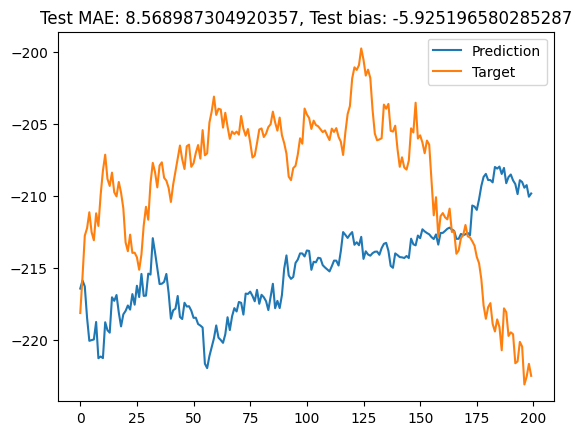

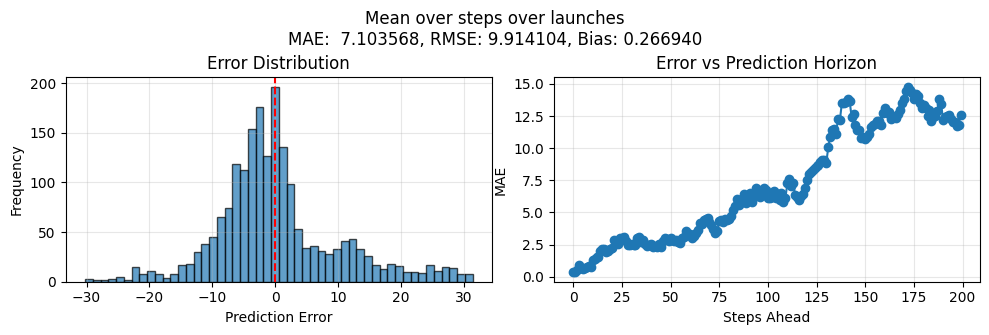

Epoch: 37
Batch IDX: 0
{'MAE': 0.3514089584350586, 'MSE': 0.2527376115322113, 'MAPE': 1.2563906610012054}
{'entropy': 1.5555676221847534, 'active': 1.0, 'means_std': 0.1861325353384018, 'stds_mean': 1.4511827230453491, 'stds_std': 0.5206194519996643, 'corr': -0.058714427053928375, 'EM weights': tensor([[1.0596, 0.8362, 1.0701, 1.0320, 0.9329, 0.9195, 0.9453, 0.9588, 1.0569,
         0.9045, 0.9983, 0.8972, 0.9459, 0.9455, 0.8988, 0.9192, 1.0170, 0.9284,
         0.9751, 1.0116, 1.0810, 0.8897, 1.0324, 0.9644, 1.0347, 1.1155, 1.1248,
         1.0926, 1.0508, 0.8669, 1.0052, 1.0056, 1.0154, 0.7794, 0.8412, 1.0307,
         0.8759, 0.8975, 0.9265, 0.9446, 0.9541, 1.0707, 0.9532, 1.0780, 0.9878,
         1.0533, 1.1141, 1.1151, 0.8813, 1.0996, 0.9396, 0.9619, 0.8918, 1.0555,
         0.8604, 1.0015, 1.1056, 0.9896, 0.9520, 1.1144, 0.9695, 0.9680, 0.8535,
         1.1715, 0.9598, 1.1337, 0.9081, 0.9278, 0.9780, 0.9342, 1.1978, 0.9489,
         1.0066, 1.1086, 1.0418, 0.9542, 1.0381, 0.9272,

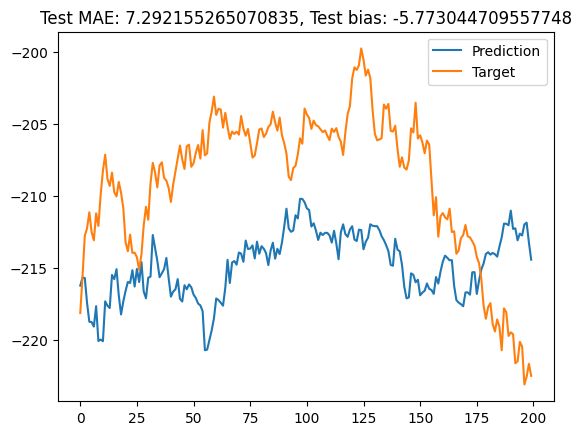

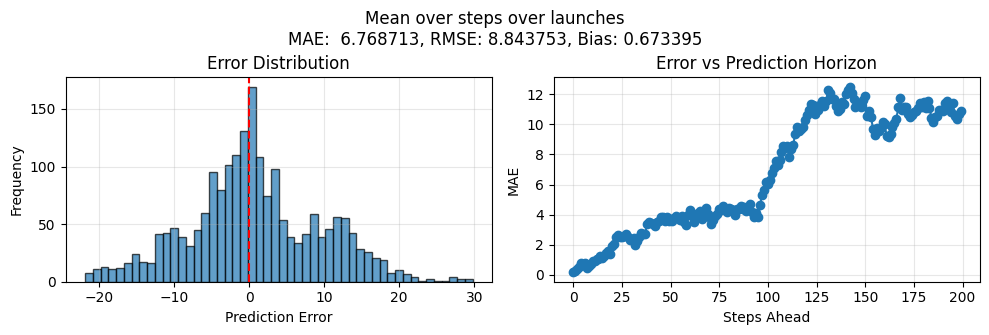

Epoch: 38
Batch IDX: 0
{'MAE': 0.3634759187698364, 'MSE': 0.24159197509288788, 'MAPE': 2.9482953250408173}
{'entropy': 1.5540043115615845, 'active': 1.0, 'means_std': 0.1834309846162796, 'stds_mean': 1.3555196523666382, 'stds_std': 0.41585713624954224, 'corr': -0.04326651617884636, 'EM weights': tensor([[1.0591, 0.8374, 1.0710, 1.0319, 0.9338, 0.9164, 0.9444, 0.9590, 1.0556,
         0.9041, 0.9979, 0.8971, 0.9445, 0.9475, 0.8979, 0.9194, 1.0160, 0.9305,
         0.9746, 1.0101, 1.0819, 0.8898, 1.0340, 0.9655, 1.0337, 1.1179, 1.1257,
         1.0962, 1.0478, 0.8630, 1.0046, 1.0022, 1.0149, 0.7769, 0.8382, 1.0286,
         0.8777, 0.8955, 0.9275, 0.9434, 0.9542, 1.0706, 0.9540, 1.0743, 0.9866,
         1.0529, 1.1096, 1.1157, 0.8775, 1.0984, 0.9420, 0.9581, 0.8913, 1.0553,
         0.8597, 0.9996, 1.1074, 0.9893, 0.9505, 1.1125, 0.9724, 0.9663, 0.8486,
         1.1695, 0.9635, 1.1364, 0.9074, 0.9267, 0.9799, 0.9355, 1.1998, 0.9494,
         1.0071, 1.1107, 1.0398, 0.9546, 1.0402, 0.9283

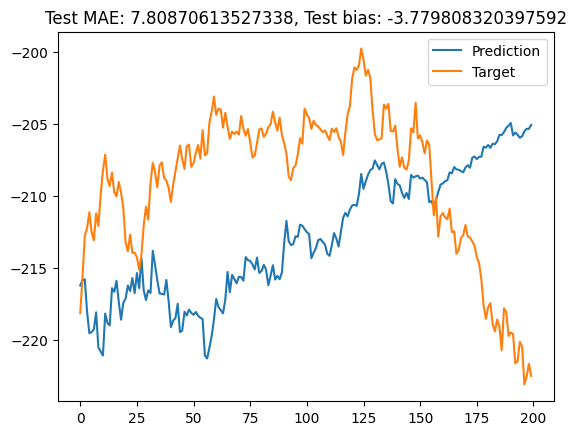

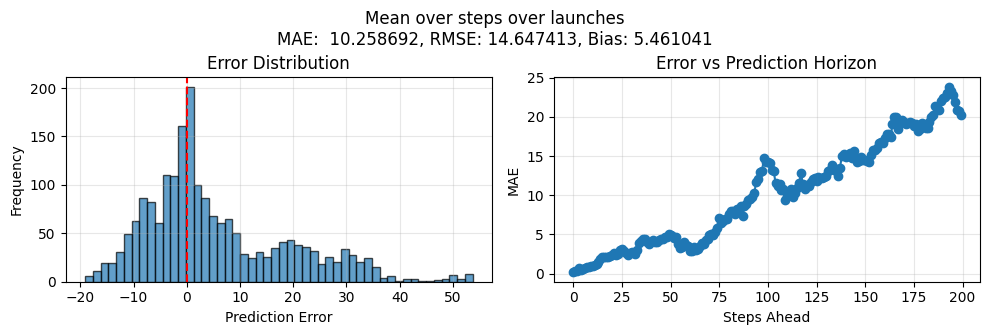

Epoch: 39
Batch IDX: 0
{'MAE': 0.3808209002017975, 'MSE': 0.3496716022491455, 'MAPE': 7.501696795225143}
{'entropy': 1.5515072345733643, 'active': 0.9984375238418579, 'means_std': 0.18485496938228607, 'stds_mean': 1.3605263233184814, 'stds_std': 0.4812593460083008, 'corr': -0.003872149158269167, 'EM weights': tensor([[1.0593, 0.8374, 1.0714, 1.0292, 0.9341, 0.9191, 0.9436, 0.9603, 1.0585,
         0.9020, 1.0015, 0.8981, 0.9446, 0.9467, 0.8968, 0.9168, 1.0146, 0.9282,
         0.9744, 1.0057, 1.0797, 0.8865, 1.0348, 0.9673, 1.0347, 1.1183, 1.1244,
         1.0972, 1.0491, 0.8610, 1.0049, 1.0024, 1.0190, 0.7719, 0.8388, 1.0265,
         0.8817, 0.8925, 0.9272, 0.9445, 0.9525, 1.0706, 0.9513, 1.0741, 0.9867,
         1.0505, 1.1069, 1.1122, 0.8785, 1.0979, 0.9402, 0.9576, 0.8912, 1.0559,
         0.8584, 0.9978, 1.1112, 0.9918, 0.9478, 1.1157, 0.9748, 0.9641, 0.8454,
         1.1671, 0.9620, 1.1412, 0.9074, 0.9272, 0.9807, 0.9391, 1.2002, 0.9498,
         1.0116, 1.1059, 1.0390, 0.9580, 

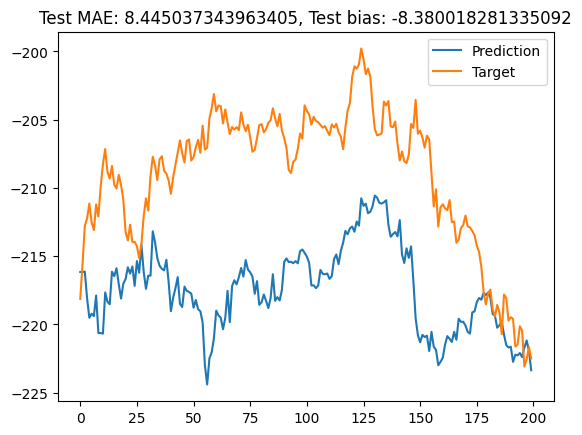

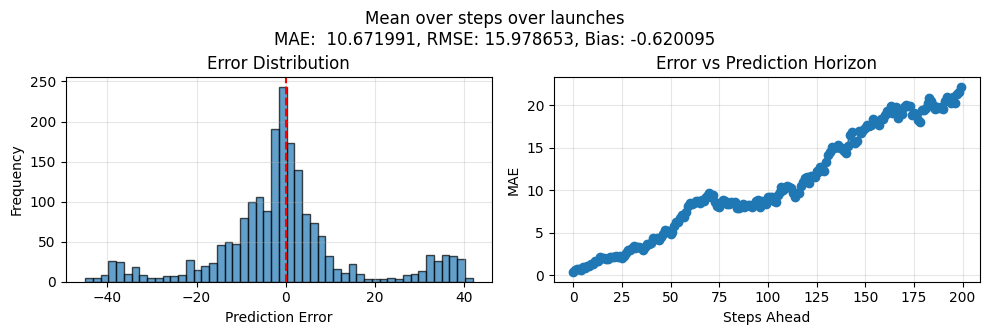

Epoch: 40
Batch IDX: 0
{'MAE': 0.3067142367362976, 'MSE': 0.17608976364135742, 'MAPE': 1.0200083255767822}
{'entropy': 1.5558369159698486, 'active': 1.0, 'means_std': 0.18240749835968018, 'stds_mean': 1.4398837089538574, 'stds_std': 0.4477860927581787, 'corr': -0.06368061155080795, 'EM weights': tensor([[1.0616, 0.8378, 1.0705, 1.0279, 0.9335, 0.9194, 0.9427, 0.9625, 1.0577,
         0.9014, 1.0008, 0.8965, 0.9453, 0.9480, 0.8966, 0.9165, 1.0140, 0.9275,
         0.9755, 1.0047, 1.0771, 0.8851, 1.0355, 0.9696, 1.0334, 1.1182, 1.1268,
         1.0956, 1.0501, 0.8577, 1.0051, 1.0019, 1.0193, 0.7684, 0.8368, 1.0257,
         0.8811, 0.8914, 0.9264, 0.9429, 0.9496, 1.0719, 0.9508, 1.0718, 0.9868,
         1.0500, 1.1079, 1.1131, 0.8760, 1.0978, 0.9409, 0.9569, 0.8909, 1.0526,
         0.8579, 0.9978, 1.1149, 0.9922, 0.9437, 1.1172, 0.9758, 0.9650, 0.8411,
         1.1675, 0.9608, 1.1410, 0.9070, 0.9270, 0.9771, 0.9407, 1.2013, 0.9513,
         1.0070, 1.1066, 1.0369, 0.9576, 1.0420, 0.9323

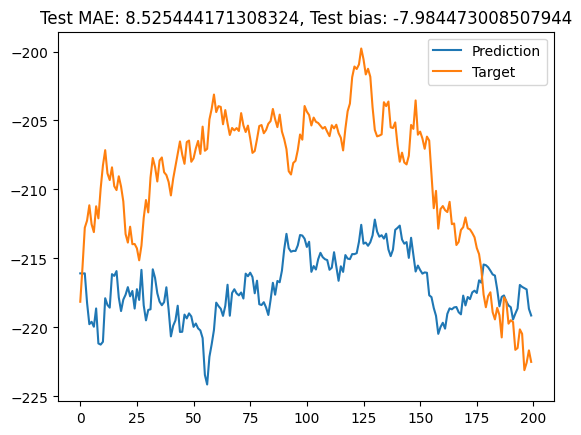

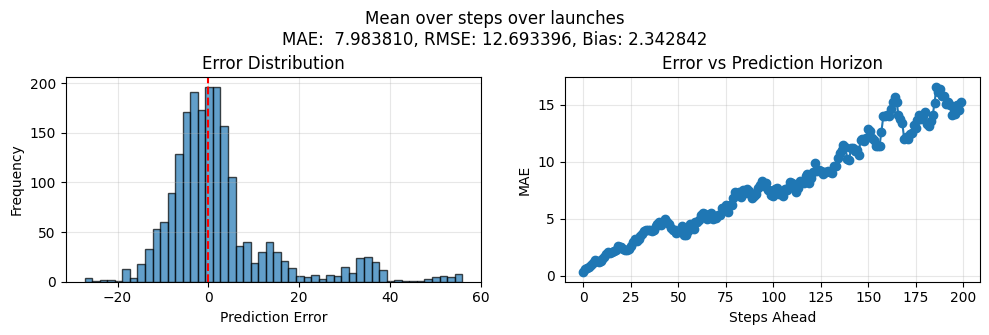

Epoch: 41
Batch IDX: 0
{'MAE': 0.30062365531921387, 'MSE': 0.1717691421508789, 'MAPE': 0.8336870931088924}
{'entropy': 1.5516078472137451, 'active': 1.0, 'means_std': 0.17783774435520172, 'stds_mean': 1.3704805374145508, 'stds_std': 0.4191955029964447, 'corr': -0.002007713308557868, 'EM weights': tensor([[1.0594, 0.8394, 1.0715, 1.0254, 0.9327, 0.9188, 0.9417, 0.9627, 1.0592,
         0.8982, 1.0017, 0.8967, 0.9459, 0.9463, 0.8987, 0.9163, 1.0166, 0.9252,
         0.9758, 1.0045, 1.0770, 0.8832, 1.0338, 0.9715, 1.0313, 1.1164, 1.1245,
         1.1000, 1.0487, 0.8547, 1.0035, 1.0007, 1.0181, 0.7648, 0.8363, 1.0242,
         0.8865, 0.8914, 0.9263, 0.9437, 0.9499, 1.0718, 0.9504, 1.0679, 0.9869,
         1.0502, 1.1105, 1.1127, 0.8743, 1.0952, 0.9422, 0.9556, 0.8924, 1.0508,
         0.8559, 0.9946, 1.1229, 0.9935, 0.9427, 1.1190, 0.9771, 0.9641, 0.8397,
         1.1651, 0.9627, 1.1429, 0.9083, 0.9270, 0.9770, 0.9425, 1.2012, 0.9501,
         1.0094, 1.1082, 1.0397, 0.9585, 1.0425, 0.933

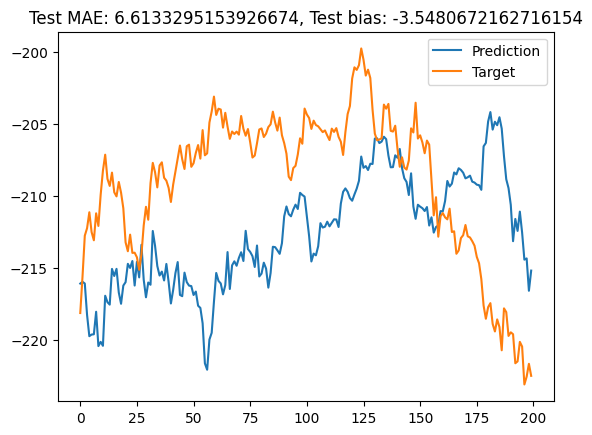

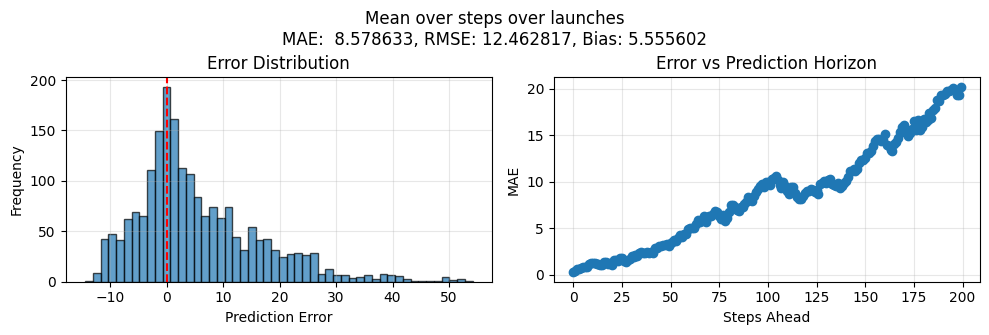

Epoch: 42
Batch IDX: 0
{'MAE': 0.3160027861595154, 'MSE': 0.17988578975200653, 'MAPE': 1.0516302660107613}
{'entropy': 1.551297664642334, 'active': 1.0, 'means_std': 0.21558718383312225, 'stds_mean': 1.447837233543396, 'stds_std': 0.5555805563926697, 'corr': -0.018791943788528442, 'EM weights': tensor([[1.0587, 0.8405, 1.0691, 1.0250, 0.9328, 0.9198, 0.9391, 0.9623, 1.0559,
         0.8976, 1.0007, 0.8964, 0.9454, 0.9481, 0.8986, 0.9155, 1.0152, 0.9273,
         0.9752, 1.0027, 1.0764, 0.8813, 1.0345, 0.9715, 1.0328, 1.1197, 1.1262,
         1.1006, 1.0488, 0.8526, 1.0050, 0.9970, 1.0186, 0.7644, 0.8382, 1.0241,
         0.8875, 0.8882, 0.9248, 0.9429, 0.9488, 1.0724, 0.9486, 1.0674, 0.9879,
         1.0499, 1.1138, 1.1127, 0.8740, 1.0952, 0.9439, 0.9557, 0.8931, 1.0531,
         0.8556, 0.9919, 1.1241, 0.9951, 0.9399, 1.1195, 0.9768, 0.9631, 0.8365,
         1.1643, 0.9636, 1.1402, 0.9067, 0.9281, 0.9780, 0.9461, 1.2027, 0.9514,
         1.0123, 1.1065, 1.0388, 0.9554, 1.0439, 0.9364,

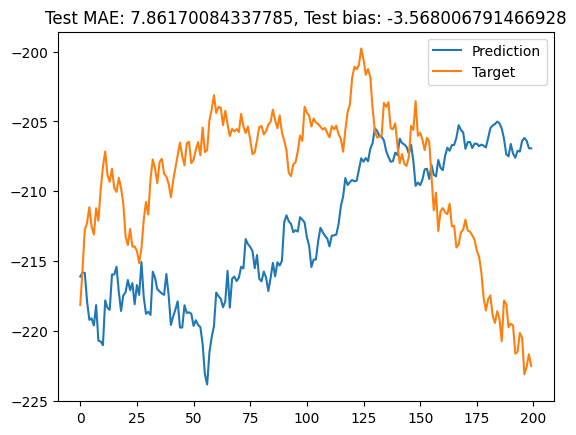

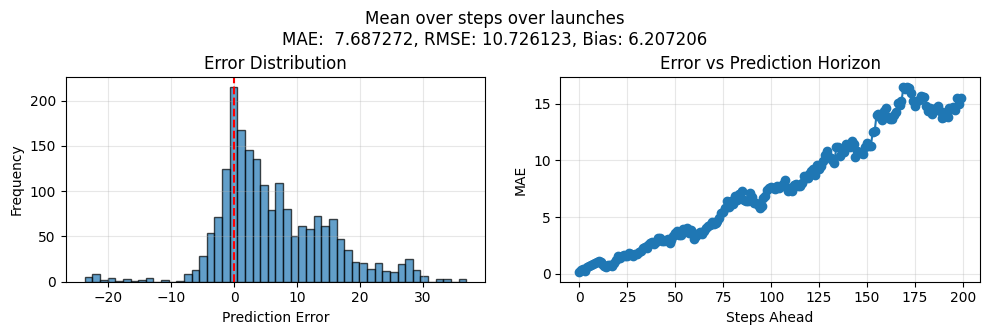

Epoch: 43
Batch IDX: 0
{'MAE': 0.29712167382240295, 'MSE': 0.1812829077243805, 'MAPE': 2.5102226063609123}
{'entropy': 1.5501328706741333, 'active': 1.0, 'means_std': 0.20495717227458954, 'stds_mean': 1.475549578666687, 'stds_std': 0.5315647721290588, 'corr': 0.022801248356699944, 'EM weights': tensor([[1.0577, 0.8408, 1.0718, 1.0248, 0.9335, 0.9206, 0.9403, 0.9642, 1.0562,
         0.8981, 1.0016, 0.8966, 0.9453, 0.9495, 0.8990, 0.9165, 1.0157, 0.9269,
         0.9755, 1.0015, 1.0762, 0.8796, 1.0334, 0.9731, 1.0314, 1.1214, 1.1224,
         1.0998, 1.0501, 0.8508, 1.0054, 0.9949, 1.0178, 0.7634, 0.8360, 1.0234,
         0.8868, 0.8880, 0.9251, 0.9424, 0.9480, 1.0730, 0.9465, 1.0650, 0.9886,
         1.0492, 1.1157, 1.1120, 0.8736, 1.0945, 0.9469, 0.9564, 0.8947, 1.0515,
         0.8563, 0.9895, 1.1253, 0.9968, 0.9396, 1.1193, 0.9797, 0.9624, 0.8357,
         1.1638, 0.9638, 1.1401, 0.9066, 0.9274, 0.9771, 0.9466, 1.2043, 0.9504,
         1.0161, 1.1065, 1.0420, 0.9565, 1.0432, 0.9357,

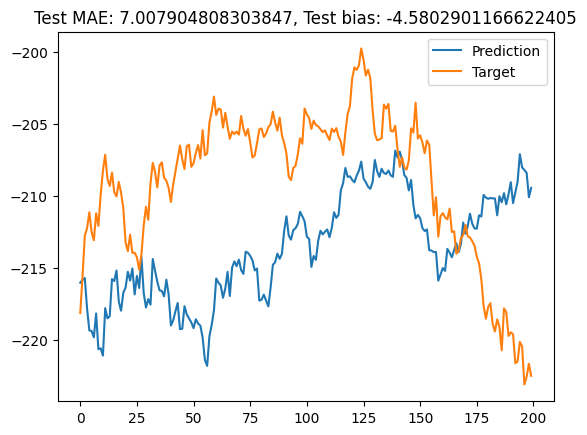

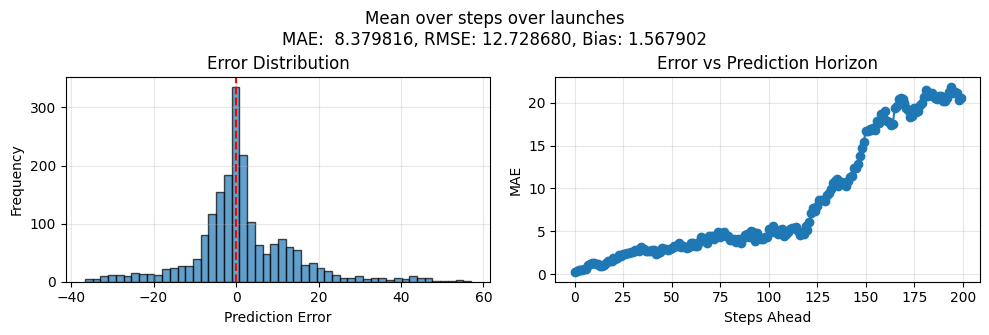

Epoch: 44
Batch IDX: 0
{'MAE': 0.27409327030181885, 'MSE': 0.17455656826496124, 'MAPE': 0.8373253047466278}
{'entropy': 1.5566288232803345, 'active': 1.0, 'means_std': 0.17916598916053772, 'stds_mean': 1.4380868673324585, 'stds_std': 0.4642821252346039, 'corr': 0.09293133020401001, 'EM weights': tensor([[1.0558, 0.8423, 1.0725, 1.0247, 0.9341, 0.9220, 0.9396, 0.9622, 1.0548,
         0.8968, 1.0008, 0.8953, 0.9460, 0.9490, 0.8991, 0.9159, 1.0170, 0.9280,
         0.9757, 1.0012, 1.0756, 0.8789, 1.0330, 0.9746, 1.0309, 1.1206, 1.1251,
         1.1008, 1.0507, 0.8493, 1.0049, 0.9935, 1.0209, 0.7623, 0.8347, 1.0236,
         0.8879, 0.8865, 0.9245, 0.9401, 0.9465, 1.0745, 0.9470, 1.0631, 0.9884,
         1.0484, 1.1177, 1.1120, 0.8728, 1.0943, 0.9475, 0.9561, 0.8945, 1.0522,
         0.8552, 0.9890, 1.1273, 0.9980, 0.9396, 1.1177, 0.9802, 0.9598, 0.8334,
         1.1625, 0.9622, 1.1415, 0.9072, 0.9277, 0.9771, 0.9472, 1.2037, 0.9498,
         1.0173, 1.1079, 1.0397, 0.9548, 1.0446, 0.9376

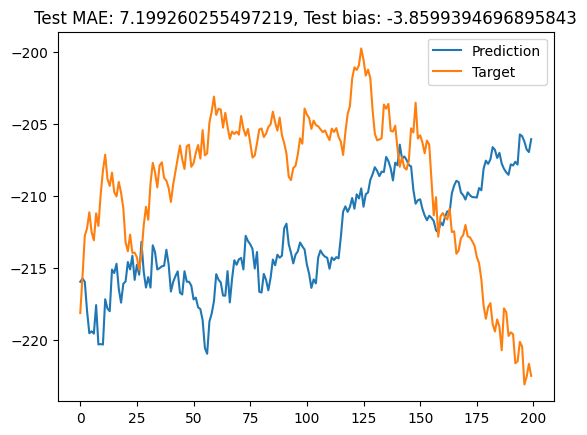

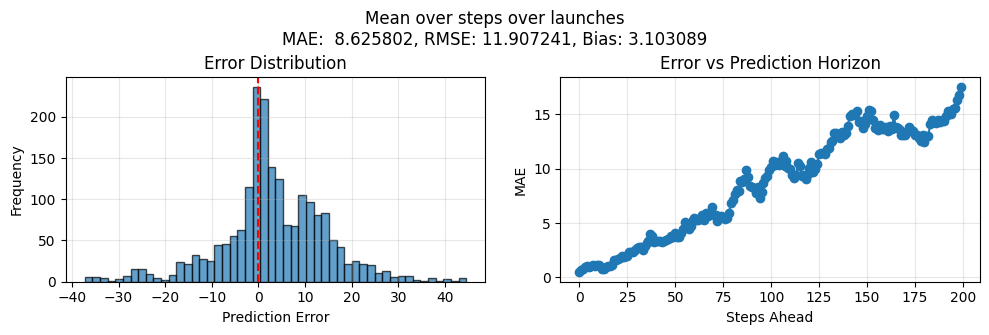

Epoch: 45
Batch IDX: 0
{'MAE': 0.28619566559791565, 'MSE': 0.19899815320968628, 'MAPE': 1.3240818865597248}
{'entropy': 1.549700379371643, 'active': 1.0, 'means_std': 0.1984381526708603, 'stds_mean': 1.4129196405410767, 'stds_std': 0.49083563685417175, 'corr': -0.01749231666326523, 'EM weights': tensor([[1.0540, 0.8427, 1.0745, 1.0228, 0.9348, 0.9201, 0.9390, 0.9635, 1.0549,
         0.8958, 1.0000, 0.8951, 0.9466, 0.9505, 0.8990, 0.9155, 1.0181, 0.9278,
         0.9750, 1.0000, 1.0745, 0.8784, 1.0329, 0.9756, 1.0317, 1.1223, 1.1237,
         1.0993, 1.0502, 0.8482, 1.0055, 0.9915, 1.0201, 0.7607, 0.8349, 1.0231,
         0.8896, 0.8855, 0.9240, 0.9401, 0.9453, 1.0735, 0.9468, 1.0625, 0.9881,
         1.0480, 1.1165, 1.1110, 0.8729, 1.0926, 0.9482, 0.9547, 0.8948, 1.0524,
         0.8548, 0.9879, 1.1295, 1.0007, 0.9393, 1.1180, 0.9823, 0.9602, 0.8324,
         1.1623, 0.9610, 1.1418, 0.9064, 0.9272, 0.9780, 0.9485, 1.2041, 0.9502,
         1.0187, 1.1080, 1.0398, 0.9548, 1.0449, 0.9382

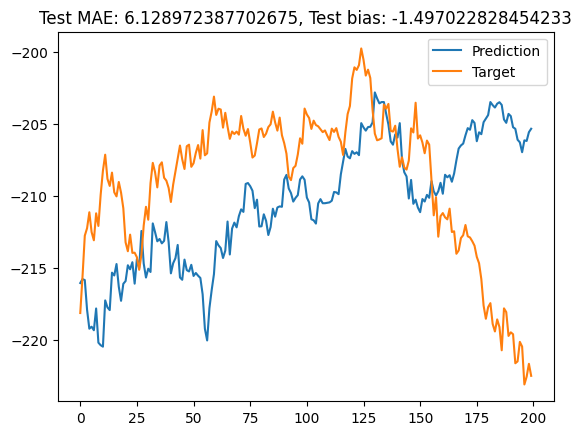

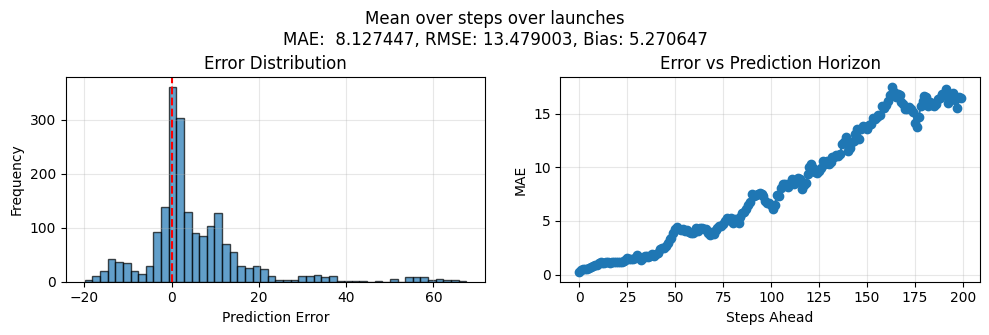

Epoch: 46
Batch IDX: 0
{'MAE': 0.2556252181529999, 'MSE': 0.13598603010177612, 'MAPE': 0.6368444301187992}
{'entropy': 1.551576018333435, 'active': 1.0, 'means_std': 0.17292557656764984, 'stds_mean': 1.4275665283203125, 'stds_std': 0.3848452568054199, 'corr': -0.03455853462219238, 'EM weights': tensor([[1.0537, 0.8442, 1.0741, 1.0219, 0.9360, 0.9209, 0.9383, 0.9645, 1.0547,
         0.8961, 0.9991, 0.8945, 0.9457, 0.9510, 0.9003, 0.9156, 1.0173, 0.9283,
         0.9761, 1.0006, 1.0740, 0.8768, 1.0317, 0.9775, 1.0309, 1.1239, 1.1251,
         1.1013, 1.0499, 0.8468, 1.0065, 0.9905, 1.0211, 0.7603, 0.8352, 1.0215,
         0.8905, 0.8843, 0.9237, 0.9385, 0.9445, 1.0742, 0.9467, 1.0597, 0.9881,
         1.0471, 1.1192, 1.1105, 0.8718, 1.0914, 0.9489, 0.9559, 0.8961, 1.0530,
         0.8529, 0.9876, 1.1303, 0.9996, 0.9389, 1.1177, 0.9830, 0.9597, 0.8310,
         1.1618, 0.9598, 1.1424, 0.9063, 0.9288, 0.9791, 0.9507, 1.2049, 0.9498,
         1.0205, 1.1069, 1.0387, 0.9531, 1.0461, 0.9373,

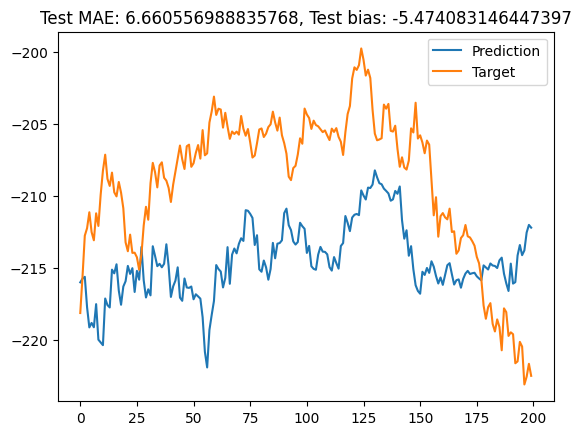

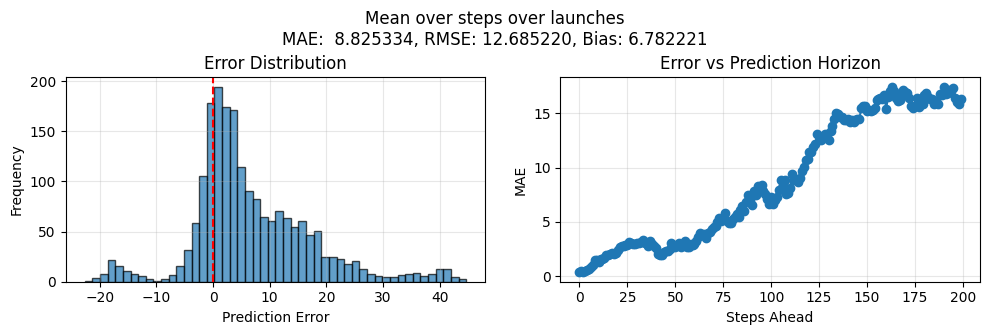

Epoch: 47
Batch IDX: 0
{'MAE': 0.2759847044944763, 'MSE': 0.15070277452468872, 'MAPE': 0.9472068399190903}
{'entropy': 1.5499757528305054, 'active': 1.0, 'means_std': 0.1952764093875885, 'stds_mean': 1.418113350868225, 'stds_std': 0.5004965662956238, 'corr': -0.02218802273273468, 'EM weights': tensor([[1.0543, 0.8437, 1.0748, 1.0207, 0.9357, 0.9207, 0.9378, 0.9644, 1.0544,
         0.8959, 0.9989, 0.8937, 0.9456, 0.9521, 0.9001, 0.9155, 1.0172, 0.9285,
         0.9749, 1.0005, 1.0746, 0.8768, 1.0326, 0.9778, 1.0311, 1.1247, 1.1246,
         1.1007, 1.0497, 0.8459, 1.0063, 0.9899, 1.0220, 0.7589, 0.8356, 1.0208,
         0.8910, 0.8846, 0.9231, 0.9375, 0.9441, 1.0752, 0.9462, 1.0580, 0.9866,
         1.0467, 1.1188, 1.1096, 0.8715, 1.0908, 0.9489, 0.9560, 0.8960, 1.0513,
         0.8521, 0.9871, 1.1313, 0.9998, 0.9385, 1.1185, 0.9833, 0.9598, 0.8295,
         1.1609, 0.9593, 1.1424, 0.9063, 0.9271, 0.9793, 0.9515, 1.2057, 0.9499,
         1.0208, 1.1066, 1.0386, 0.9535, 1.0459, 0.9392, 

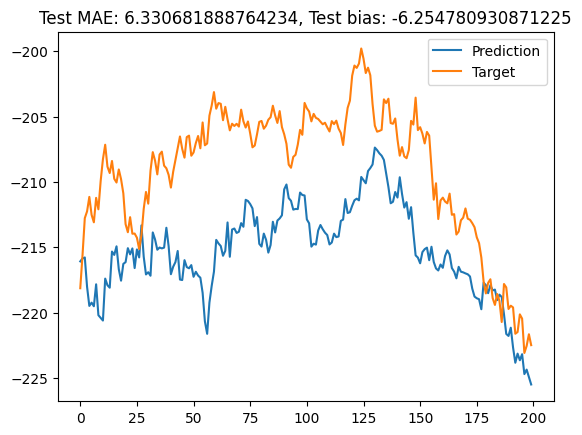

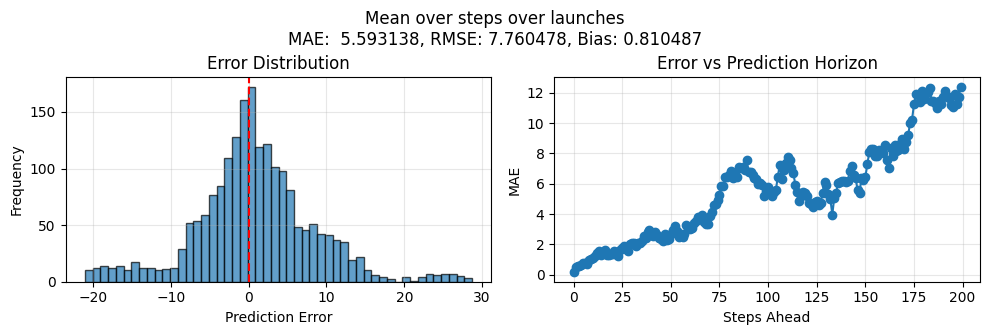

Epoch: 48
Batch IDX: 0
{'MAE': 0.26828259229660034, 'MSE': 0.19245052337646484, 'MAPE': 0.9688083082437515}
{'entropy': 1.548777461051941, 'active': 1.0, 'means_std': 0.20057931542396545, 'stds_mean': 1.4177602529525757, 'stds_std': 0.4688383638858795, 'corr': 0.006022501736879349, 'EM weights': tensor([[1.0544, 0.8441, 1.0749, 1.0207, 0.9365, 0.9207, 0.9368, 0.9643, 1.0547,
         0.8954, 0.9981, 0.8934, 0.9455, 0.9520, 0.9003, 0.9153, 1.0168, 0.9279,
         0.9745, 1.0011, 1.0741, 0.8757, 1.0320, 0.9792, 1.0302, 1.1251, 1.1256,
         1.1008, 1.0502, 0.8453, 1.0073, 0.9887, 1.0220, 0.7581, 0.8348, 1.0200,
         0.8910, 0.8846, 0.9224, 0.9376, 0.9435, 1.0754, 0.9454, 1.0568, 0.9868,
         1.0473, 1.1193, 1.1090, 0.8704, 1.0899, 0.9496, 0.9555, 0.8963, 1.0519,
         0.8514, 0.9852, 1.1335, 1.0003, 0.9375, 1.1191, 0.9840, 0.9594, 0.8291,
         1.1605, 0.9587, 1.1421, 0.9062, 0.9268, 0.9799, 0.9523, 1.2063, 0.9502,
         1.0227, 1.1073, 1.0388, 0.9534, 1.0460, 0.9399

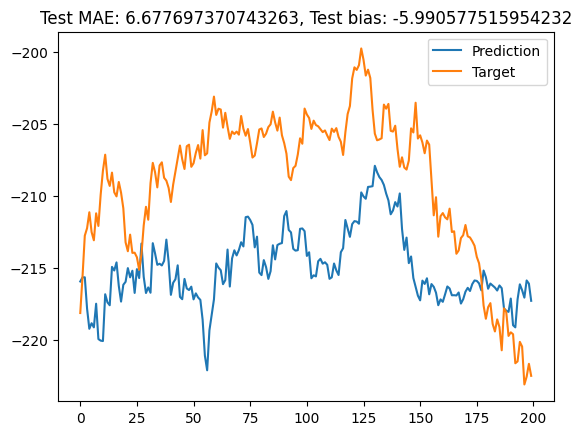

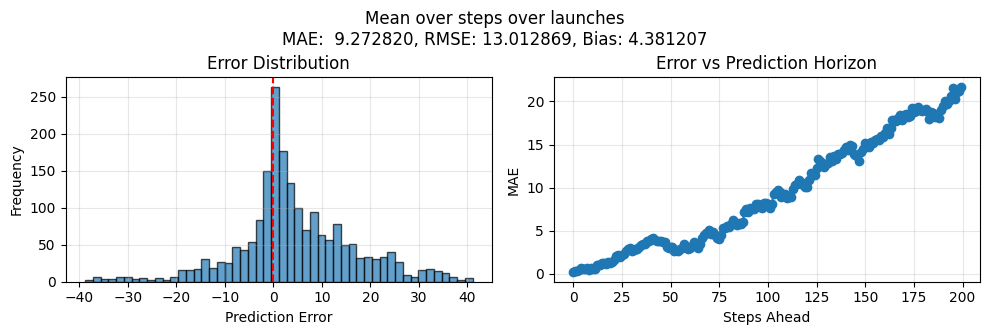

Epoch: 49
Batch IDX: 0
{'MAE': 0.22281765937805176, 'MSE': 0.16450431942939758, 'MAPE': 0.8073445409536362}
{'entropy': 1.5477252006530762, 'active': 1.0, 'means_std': 0.21311359107494354, 'stds_mean': 1.4671766757965088, 'stds_std': 0.5372541546821594, 'corr': -0.017961766570806503, 'EM weights': tensor([[1.0544, 0.8443, 1.0754, 1.0202, 0.9370, 0.9208, 0.9363, 0.9647, 1.0556,
         0.8958, 0.9979, 0.8934, 0.9457, 0.9516, 0.9008, 0.9155, 1.0168, 0.9283,
         0.9742, 1.0010, 1.0742, 0.8755, 1.0322, 0.9798, 1.0296, 1.1256, 1.1261,
         1.1015, 1.0495, 0.8445, 1.0073, 0.9881, 1.0222, 0.7571, 0.8352, 1.0190,
         0.8917, 0.8840, 0.9220, 0.9376, 0.9428, 1.0750, 0.9449, 1.0557, 0.9863,
         1.0469, 1.1203, 1.1092, 0.8704, 1.0897, 0.9498, 0.9553, 0.8968, 1.0513,
         0.8509, 0.9846, 1.1348, 1.0001, 0.9371, 1.1192, 0.9837, 0.9592, 0.8284,
         1.1602, 0.9588, 1.1426, 0.9061, 0.9263, 0.9805, 0.9526, 1.2070, 0.9498,
         1.0235, 1.1077, 1.0392, 0.9530, 1.0461, 0.94

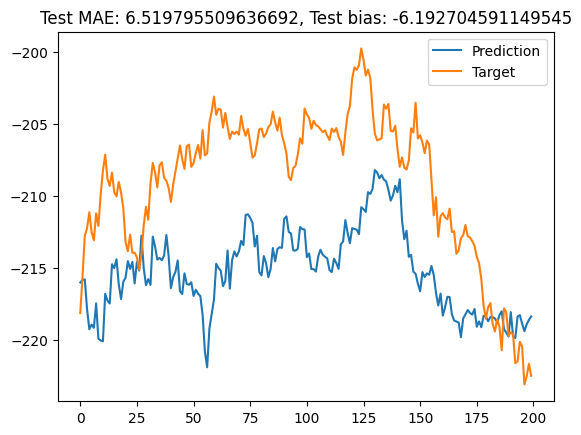

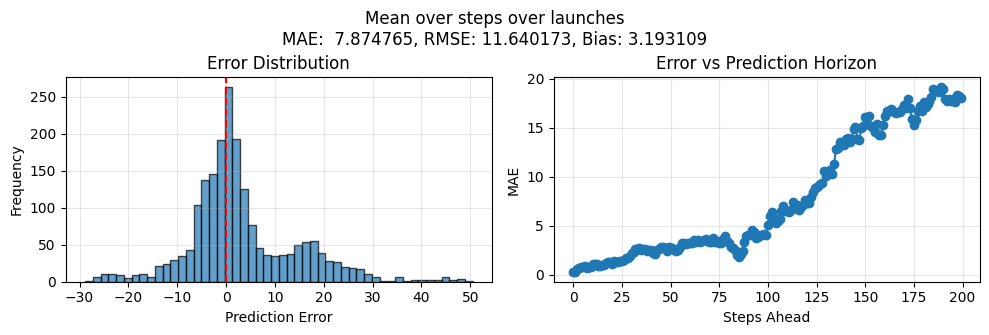

Epoch: 50
Batch IDX: 0
{'MAE': 0.23141658306121826, 'MSE': 0.1477629542350769, 'MAPE': 1.0159976780414581}
{'entropy': 1.547270655632019, 'active': 1.0, 'means_std': 0.21592187881469727, 'stds_mean': 1.4049217700958252, 'stds_std': 0.509559154510498, 'corr': -0.013938185758888721, 'EM weights': tensor([[1.0542, 0.8448, 1.0756, 1.0196, 0.9372, 0.9207, 0.9359, 0.9646, 1.0555,
         0.8956, 0.9975, 0.8930, 0.9459, 0.9516, 0.9011, 0.9157, 1.0167, 0.9281,
         0.9741, 1.0010, 1.0737, 0.8751, 1.0324, 0.9799, 1.0297, 1.1255, 1.1266,
         1.1016, 1.0494, 0.8441, 1.0073, 0.9879, 1.0222, 0.7566, 0.8351, 1.0187,
         0.8920, 0.8836, 0.9220, 0.9372, 0.9427, 1.0753, 0.9445, 1.0551, 0.9860,
         1.0468, 1.1205, 1.1086, 0.8705, 1.0894, 0.9500, 0.9554, 0.8970, 1.0511,
         0.8507, 0.9841, 1.1352, 1.0004, 0.9371, 1.1195, 0.9838, 0.9589, 0.8281,
         1.1595, 0.9588, 1.1429, 0.9063, 0.9260, 0.9806, 0.9531, 1.2075, 0.9496,
         1.0241, 1.1080, 1.0391, 0.9527, 1.0464, 0.9406,

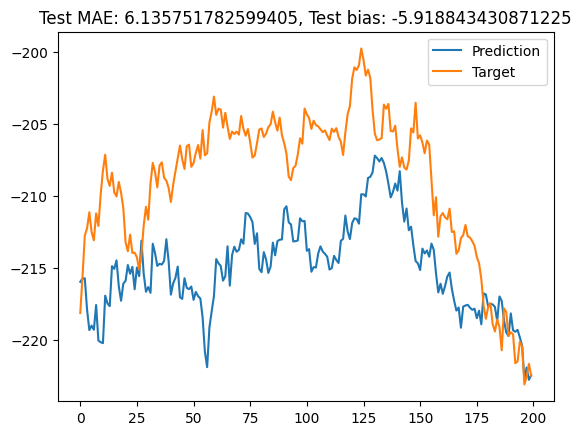

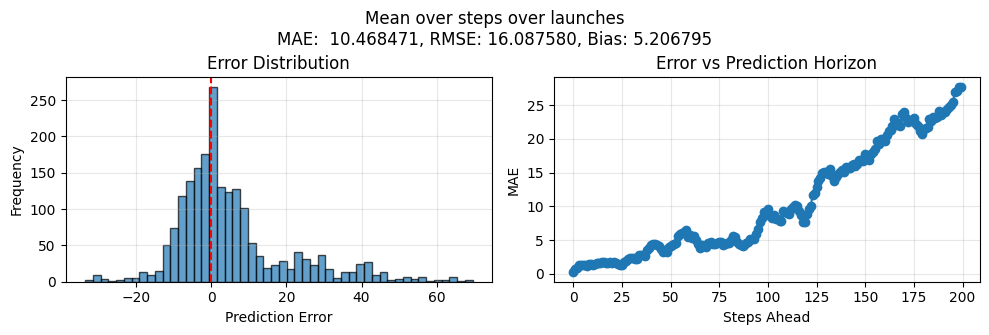


Training completed!


In [4]:
trainer = Trainer(series, int(0.9 * len(series)), n_train_steps=1, lr=1e-2, sch_last_lr=1e-8, n_epochs=50, batch_size=128, n_components=5, alpha=0.75, log_freq_batch=70, n_tests=10, n_test_steps=200, device='cuda')
model = trainer.run()

In [1]:
horizon = 50
idx = random.randint(model.window_size + 100, int(0.8 * len(series)) - 1 - horizon)
preds = model.generate_forecast(idx, series, horizon).cpu()
idx += 1
plt.plot(range(model.window_size), series[idx - model.window_size: idx], label='history')
plt.plot(range(model.window_size, model.window_size + horizon), series[idx: idx + horizon], label='targets')
plt.plot(range(model.window_size, model.window_size + horizon), preds, label='preds')
plt.legend()
plt.show()

NameError: name 'random' is not defined

In [6]:
torch.exp(model.em_layer.weights), model.em_layer.init_centers, model.em_layer.init_scales

(tensor([[1.0542, 0.8448, 1.0758, 1.0195, 0.9375, 0.9209, 0.9357, 0.9649, 1.0556,
          0.8955, 0.9975, 0.8929, 0.9459, 0.9517, 0.9011, 0.9157, 1.0167, 0.9281,
          0.9740, 1.0009, 1.0735, 0.8749, 1.0325, 0.9803, 1.0295, 1.1256, 1.1268,
          1.1017, 1.0493, 0.8438, 1.0074, 0.9879, 1.0222, 0.7565, 0.8351, 1.0184,
          0.8921, 0.8835, 0.9219, 0.9372, 0.9425, 1.0756, 0.9443, 1.0547, 0.9859,
          1.0467, 1.1204, 1.1086, 0.8703, 1.0892, 0.9501, 0.9555, 0.8971, 1.0511,
          0.8506, 0.9838, 1.1357, 1.0004, 0.9370, 1.1195, 0.9840, 0.9588, 0.8279,
          1.1594, 0.9588, 1.1430, 0.9062, 0.9259, 0.9808, 0.9534, 1.2076, 0.9494,
          1.0243, 1.1079, 1.0389, 0.9525, 1.0466, 0.9410, 0.9963, 1.0930, 0.8977,
          1.0720, 0.9040, 0.8973, 1.0463, 1.1510, 0.9504, 0.9130, 0.9503, 1.0916,
          1.0461, 0.9819, 0.9281, 1.1468, 0.9430, 0.9422, 0.9413, 1.1204, 1.1578,
          1.0750, 1.0499, 0.9994, 0.9885, 0.9636, 1.1612, 0.9633, 0.9441, 0.9881,
          1.2432

In [7]:
model.dx_linear.weight

AttributeError: 'EMForecaster' object has no attribute 'dx_linear'